In [1]:
import importlib
import json
import warnings
from urllib.request import urlopen

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from IPython.display import Markdown
from plotly.subplots import make_subplots
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.vq import whiten
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import silhouette_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.preprocessing import StandardScaler
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
# Import utility functions used to import, clean up and format datasets
import utils.graph_utils as graph_utils
import utils.process_data as process_data
import utils.helper as helper

# In case any utilities function change this automatically reimports them without having to restart the kernel
importlib.reload(process_data)
importlib.reload(graph_utils)
importlib.reload(helper)

get_facts_df_readable = process_data.get_facts_df_readable
render_fig = graph_utils.render_fig
test_corr_with_chart = graph_utils.test_corr_with_chart
test_chi_squared = graph_utils.test_chi_squared

In [3]:
# Style and other configuration

COLOR_PRIMARY_BLUE = "rgb(98,113,242)"
COLOR_PRIMARY_RED = "rgb(223,98,68)"

%config Completer.use_jedi = False

# Enable to modify outputted table sizes if needed
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 25)
# pd.set_option('display.width', 1000)

# Embed full plotly libs in exported html files for offlines use
plotly.offline.init_notebook_mode()

In [4]:
# Load state spending dataset
state_spending = process_data.load_state_spending_dataset()

# Load state homocide dataset
homocide_avg_df = process_data.load_homocide_df()

# Load state demographic facts dataset
df_facts_state = process_data.get_df_facts_df()

#Load county fips and shapefile dataset 
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [5]:
# Load main dataset and merge with shapefiles for states and counties
df_main, geo_df = process_data.load_and_process_shootings_df()

In [6]:
# Group certain categorical variables and other processing
df_main = process_data.process_main_df(df_main)

In [7]:
# Find total period in dataset for per capita yearly adjustment
TOTAL_YEARS_IN_DF = (max(df_main["date"]) - min(df_main["date"])).days / 365.24219

###  1. Introduction

The goal is to use the Washington Post police shootings and related (demographic data, state spending, homicides) datasets to try and determine whether we can provide any actionable suggestions to the US Justice Department on how to decrease the overall number of police shootings. 

The analysis is split into three parts all of which try to answer these different questions:

1. Overview of the variables in core dataset and state level analysis
    - Are certain races disproportionately affected?
    - What are the predominant circumstances and reasons police shootings occur?
    - What's the effect of other factors like victims age, gender, body camera usage etc.?
2. State level analysis and clustering based on demographic data
    - What's the relationship between state level homicide rates and the number of police shootings?
    - What effect does spending on law enforcement have?
    - Could we cluster states using  demographic and economic data to try and similar states  with varying number of police shootings (that way policies, training standard, organization structure used in those state could possibly be implemented in worse performing state)?
    
3. Building a state level statistical model which would explain the effect various socio-demographic variables have on the number of police shootings.
    - Can we find states that perform better or worse than they expected to (based on their socio-demographic profile)?
        - Can other similar states adopt some of the policies, training standards from the best performing states? 


###  2. Overview of the dataset

The goal of this part is to analyze the main shootings dataset to try and find any patterns between different races, age groups genders etc.

The purpose of which is to **determine what proportion of variance could be explained by immutable features (which law enforcement agencies can't directly affect) and whether the unexplained variance could be related to racial and other prejudices.**


#### 2.1. Chronological  Distribution of Police Shootings

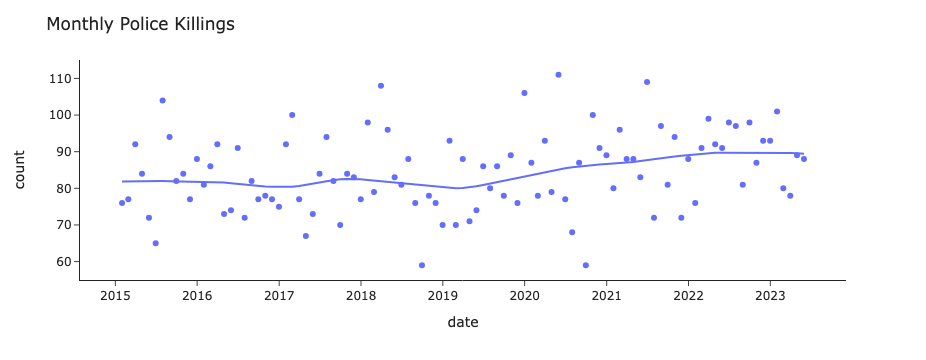

In total there were 8635 recorded police shotings between 2015-01-02 and 2023-07-22, averaging about 1010 per year

We can see the number of police shootings has been relatively stable (even though there was significant month to month variance) prior to 2020 with about 80 killings per month. In recent years it has increased to about 90

In [8]:
display(Markdown("#### 2.1. Chronological  Distribution of Police Shootings"))

ts_df = df_main.resample(rule='M', on='date').agg(
    count=('id', 'count')
).reset_index()

# Drop last two months, not all data available so doesen't make sense to include in chart
ts_df = ts_df[(ts_df['date'] < "2023-06-01")]

# Locally Weighted Scatterplot Smoothing (LOWESS) is a non-parametric method that fits a smooth curve to data, emphasizing local points.
# It reveals underlying trends without assuming a specific model, useful for complex relationships.
fig = px.scatter(ts_df, x='date', y="count", trendline="lowess", trendline_options=dict(frac=0.3))
fig.update_layout(
    title="Monthly Police Killings",
    dragmode=False,
    xaxis=dict(
        fixedrange=True
    ),
    yaxis=dict(
        fixedrange=True
    )
)

render_fig(fig)

display(Markdown(
    f"In total there were {len(df_main)} recorded police shotings between {min(df_main['date']).strftime('%Y-%m-%d')} and {max(df_main['date']).strftime('%Y-%m-%d')}, averaging about {len(df_main) / TOTAL_YEARS_IN_DF:.0f} per year"
))

display(Markdown(
    "We can see the number of police shootings has been relatively stable (even though there was significant month to month variance) prior to 2020 with about 80 killings per month. In recent years it has increased to about 90"))

In [9]:
# Calculate country wide per capita race stats
by_race_df = df_main.groupby(by=["race"]).agg(
    count=('id', 'count')
).reset_index()

df_facts_country_row = df_facts_state[df_facts_state["area_name"] == "United States"]

In [10]:
available_races = ["White", "Black", "Asian", "Native American", "Hispanic"]
main_df_races = [*available_races, "Other"]
target_cols = ["All", *available_races]
DEMO_KEYS = {
    "All": "PST045214",
    "Black": "RHI225214",
    "White": "RHI125214",
    "Asian": "RHI425214",
    "Hispanic": "RHI725214",
    "Native American": "RHI325214",
}

In [11]:
# Calculate per capita race stats for each state
by_state_df = df_main.groupby(by=["state", "race"]).agg(
    count=('id', 'count')
).reset_index()

# Append country wide row with sums for each race
country_row = by_state_df.groupby(by=["race"]).agg(
    count=('count', 'sum')
).reset_index()

country_row["state"] = "Country"
by_state_df = pd.concat([country_row, by_state_df]).reset_index().drop(["index"], axis=1)
by_state_df.insert(0, 'state', by_state_df.pop('state'))

by_state_df = by_state_df.pivot(index='state', columns='race', values='count').fillna(0).reset_index()
by_state_df["All"] = by_state_df[main_df_races].sum(axis=1)


def get_per_capita_state_func(race):
    def get_per_capita_state(row):
        first_row = df_facts_state.loc[df_facts_state.index == row["state"]].iloc[0]

        total = row[race]
        state_pop = int(first_row[f"pop_{race}"])

        # Shootings per 1 million
        val = (total / state_pop) * (1000 * 1000)
        val = val / TOTAL_YEARS_IN_DF

        return round(val, 3)

    return get_per_capita_state


for r in target_cols:
    by_state_df[f"{r} per 1000k"] = by_state_df.apply(get_per_capita_state_func(r), axis=1)


def get_diff_to_all_func(race):
    def get_diff_to_all(row):
        if row[race] < 5:
            return None

        race_prop = float(df_facts_state.loc[df_facts_state.index == row["state"]].iloc[0][DEMO_KEYS[race]])
        expected_for_race = row[f"{'All'} per 1000k"] * (race_prop / 100)

        return row[f"{race} per 1000k"] - expected_for_race

    return get_diff_to_all


for r in available_races:
    by_state_df[f"diff exp. {r}"] = by_state_df.apply(get_diff_to_all_func(r), axis=1)

#### 2.2. Racial Data

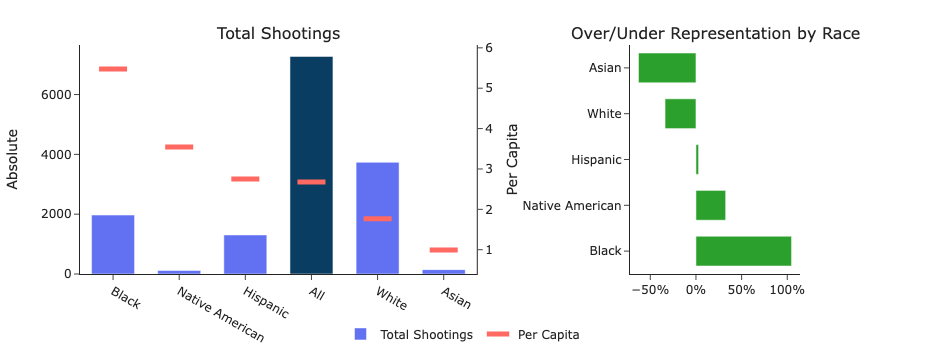

In [12]:
display(Markdown("#### 2.2. Racial Data"))
country_data = by_state_df[by_state_df["state"] == "Country"]

absolute_data = country_data[available_races]
absolute_data["All"] = absolute_data.sum(axis=1)
absolute_data.insert(0, 'All', absolute_data.pop('All'))
absolute_data = absolute_data.squeeze().to_dict()

per_capita_data = (country_data[[c for c in country_data.columns.tolist() if "per 1000k" in c]].squeeze()).to_dict()

data = {
    'Race': absolute_data.keys(),
    'Absolute': absolute_data.values(),
    'Per Capita': per_capita_data.values(),
    'Diff': per_capita_data.values()
}
chart_df = pd.DataFrame(data)
chart_df["Diff"] = (chart_df["Diff"] - chart_df[chart_df["Race"] == "All"].iloc[0]["Diff"]) / \
                   chart_df[chart_df["Race"] == "All"].iloc[0]["Diff"]

chart_df = chart_df.sort_values(by='Diff', ascending=False)

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Total Shootings', 'Over/Under Representation by Race'),
                    specs=[[{'secondary_y': True}, {}]], column_widths=[0.7, 0.3])


def add_per_capita_figure_view(_fig, _df, pos=((1, 1), (1, 2)), legend_pos=(0.5, -0.325)):
    if len(pos) != 2:
        raise Exception("add_per_capita_figure_view only supports two subplots")

    # Add Absolute values as a bar trace to the first subplot
    # Specify a color for "All"
    colors = ['#0A3D62' if x == 'All' else 'rgb(98,113,242)' for x in _df['Race']]

    _fig.add_trace(go.Bar(x=_df['Race'], y=_df['Absolute'],
                          marker_color=colors,
                          name='Total Shootings'), row=pos[0][0], col=pos[0][1])

    # Add Per Capita values as a scatter trace to the first subplot
    _fig.add_trace(go.Scatter(x=_df['Race'], y=_df['Per Capita'], mode='markers',
                              marker=dict(symbol='line-ew', size=20, line=dict(width=5, color='rgb(255, 105, 97)')),
                              name='Per Capita'), secondary_y=True, row=pos[0][0], col=pos[0][1])

    # Add Category values as a vertical bar trace to the second subplot
    _fig.add_trace(go.Bar(hovertemplate='%{x:.1%}', showlegend=False,
                          x=_df[_df["Race"] != "All"]['Diff'], y=_df[_df["Race"] != "All"]['Race'], orientation='h',
                          name='Diff'), row=pos[1][0], col=pos[1][1])

    _fig.update_yaxes(title_text='Absolute', row=pos[0][0], col=pos[0][1], secondary_y=False)
    _fig.update_yaxes(title_text='Per Capita', row=pos[0][0], col=pos[0][1], secondary_y=True)
    _fig.update_layout(legend=dict(orientation='h', yanchor='bottom',

                                   x=legend_pos[0],
                                   xanchor='center', y=legend_pos[1]),
                       margin=dict(t=45)
                       )
    _fig.update_xaxes(tickformat='.0%'
                      , row=pos[1][0], col=pos[1][1])  # Update for the specific subplot

    return _fig


fig = add_per_capita_figure_view(fig, _df=chart_df)
fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True

render_fig(fig)

We can see that **Native Americans and especially African Americans people are severely over-represented** among police shooting victims. The police shooting rate for African Americans  is two times higher than would be expected based on their population. On the other hands white and Asian people are much less likely to be shot.

We assume that that there are two explanations for this:
- Socio-demographic factors (such as higher rates of poverty) means that African Americans are more likely to engage in violent crime.
- African Americans are more likely to be victims of rocial prejudice and are more likely to be shot than White or Asian Americans while engaging in equivalent activities.

By looking at other variables and their interaction we'll try to answer which of these options is better at explaining the variance in police shootings between different racial groups.

#### 2.3 Geographic  Distribution of Police Shooting

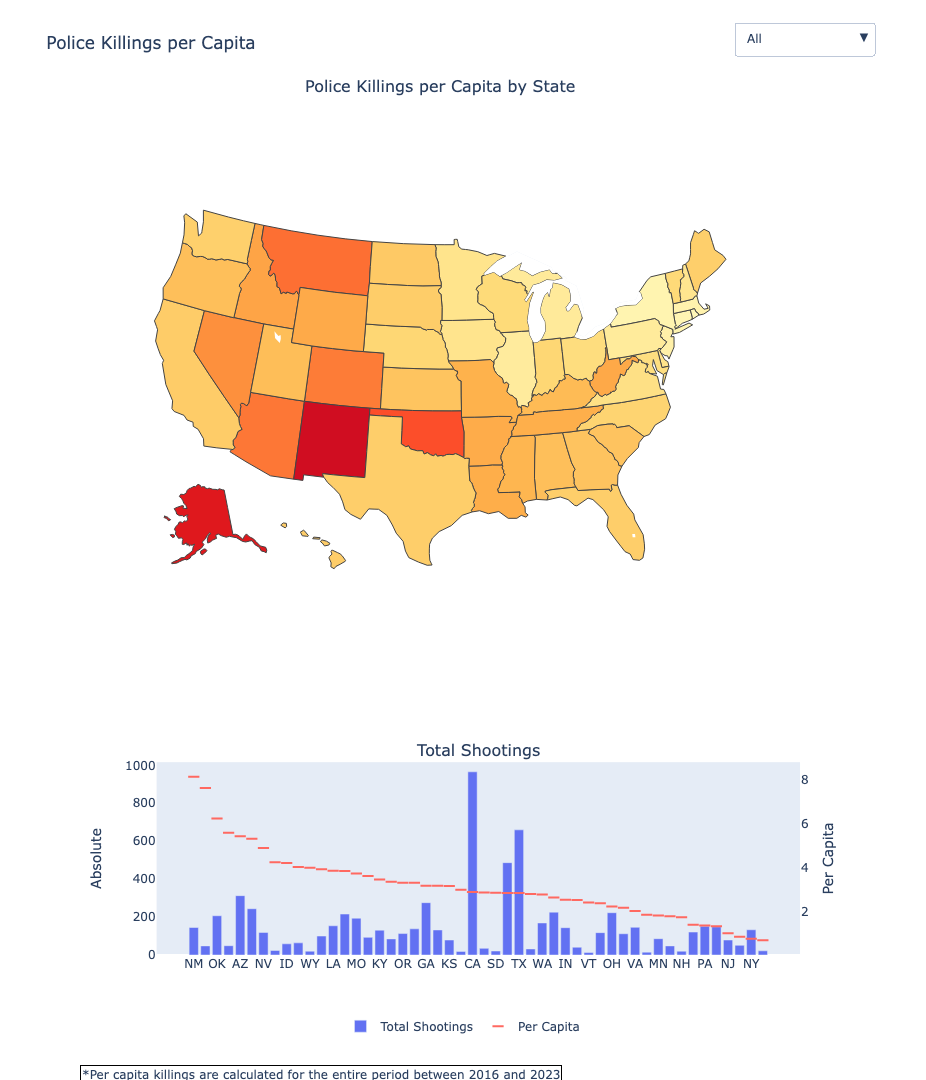

8


In [13]:
display(Markdown("#### 2.3 Geographic  Distribution of Police Shooting"))

by_state_df_filtered = by_state_df

by_state_df_filtered['Black'] = by_state_df_filtered['Black'].map(lambda x: x if x >= 5 else np.nan)
by_state_df_filtered['White'] = by_state_df_filtered['White'].map(lambda x: x if x >= 5 else np.nan)
by_state_df_filtered['Asian'] = by_state_df_filtered['Asian'].map(lambda x: x if x >= 5 else np.nan)
by_state_df_filtered['Native American'] = by_state_df_filtered['Native American'].map(lambda x: x if x >= 5 else np.nan)
by_state_df_filtered['Hispanic American"'] = by_state_df_filtered['Hispanic'].map(lambda x: x if x >= 5 else np.nan)
by_state_df_filtered['Other'] = by_state_df_filtered['Other'].map(lambda x: x if x >= 5 else np.nan)

map_title = 'Police Killings per Capita by State'

fig = make_subplots(rows=2, cols=1,
                    specs=[[{"type": "geo",
                             }],
                           [{'secondary_y': True,
                             'l': 0.1,
                             }]

                           ],  # Second row with two plots
                    subplot_titles=(map_title, "Total Shootings", "Over/Under Representation by Race"),
                    vertical_spacing=0.1,
                    row_heights=[0.75, 0.25],
                    )

colorbar = dict(
    x=0.95,
    xanchor="left")
colorbar = None


def get_country_map(_df: pd.DataFrame, key: str, hovertext: list, visible=False, z=(-10, 15), colorscale="Portland"):
    return go.Choropleth(
        visible=visible,
        z=_df[key],  # Values for color scale
        zmin=z[0],  #  min val for the color scale
        zmax=z[1],  #  max
        colorbar=colorbar,
        showscale=False,
        locations=_df['state'],  # Column with the state codes
        locationmode='USA-states',
        hovertext=hovertext,
        hoverinfo="text",

        colorscale=colorscale
    )


all_hover_labels = [f"{state}<br>Shootings per 1 million*:<br>{v:.1f}" for v, state in
                    zip(by_state_df_filtered[f'{"All"} per 1000k'], by_state_df_filtered["state"])]

fig.add_trace(
    get_country_map(
        _df=by_state_df_filtered,
        key=f'{"All"} per 1000k',
        hovertext=all_hover_labels,
        visible=True,
        z=(0, 10),
        colorscale='YlOrRd',
    ),
    row=1,
    col=1,
)

for r in available_races:
    # Add the choropleth trace
    key = f'diff exp. {r}'
    hovertext = [
        f"{state}<br>{abs(x):.1f} {'less' if x < 0 else 'more'} {key.split(' ')[-1]} people are killed per million compared all races in state"
        for x, state in zip(by_state_df_filtered[key], by_state_df_filtered["state"])]
    fig.add_trace(get_country_map(_df=by_state_df_filtered, key=key, hovertext=hovertext), row=1,
                  col=1,
                  )
buttons = []

title = "Police Killings per Capita"


def get_trace_value(race, _df):
    _df = _df[_df["state"] != "Country"]
    _df = _df[_df[race] > 5].sort_values([f"{race} per 1000k"], ascending=False)
    return _df["state"], _df[race], _df[f"{race} per 1000k"]


all_data = get_trace_value("All", by_state_df_filtered)

# Create figure
fig.add_trace(

    go.Bar(x=all_data[0], y=all_data[1], marker={'color': 'rgb(98,113,242)'}, name='Total Shootings'), row=2,
    col=1)

# Add Per Capita values as a scatter trace to the first subplot
fig.add_trace(go.Scatter(x=all_data[0],
                         y=all_data[2],
                         mode='markers',
                         marker=dict(symbol='line-ew', size=8, line=dict(width=2, color='rgb(255, 105, 97)')),
                         name='Per Capita'), secondary_y=True, row=2,
              col=1)

fig.update_yaxes(title_text='Absolute', row=2, col=1, secondary_y=False)
fig.update_yaxes(title_text='Per Capita', row=2, col=1, secondary_y=True)

for i, r in enumerate(target_cols):
    visible = [False for r in target_cols] + [True, True, True]
    visible[i] = True

    bar_plot_abs_y_label = r

    all_data = get_trace_value(r, by_state_df_filtered)

    buttons.append(dict(
        args=[
            {
                'x': [all_data[0]],
                'y': [all_data[1], all_data[2]],

                'visible': visible}
        ],

        method='update',
        label=r,
    ))

fig.update_layout(
    margin=dict(b=125, t=50),
    height=1080,
    dragmode=False,
    title=title,
    geo_scope='usa',  # Limit map scope to the USA
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=1.05,
            xanchor="right",
            y=1.1,
            yanchor="top"
        ),
    ]
)
fig.add_annotation(text='*Per capita killings are calculated for the entire period between 2016 and 2023',
                   align='center',
                   showarrow=False,
                   xref='paper',
                   yref='paper',
                   x=0,
                   y=-0.15,
                   bordercolor='black',
                   borderwidth=1)
fig.update_layout(legend=dict(orientation='h', yanchor='bottom',

                              x=0.5,
                              xanchor='center', y=-0.1),
                  margin=dict(t=45)
                  )

# render_fig(fig)
fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True
fig.update_xaxes(showgrid=False, row=2, col=1)
fig.update_yaxes(showgrid=False, row=2, col=1)

fig.show(config={'displayModeBar': False})

print(len(fig.data))

Then map above compares the number police shootings per capita across different states. The drop down in the top right might be used to select different races. When a specific race is selected the map show by how much are different racial groups over/under represented compared to the general state population.

Looking at the state level data we can see that:
- Generally **north-eastern states have the lowest incidence of police shootings**.
- Shootings of black people (relative to population are most frequent in Midwestern and western states), the only state were black people are significantly over-represented in the east is West Virginia.

In [14]:
black_key = "Black or African American alone, percent"
hispanic_key = "Hispanic or Latino, percent"

state_race_prop_df = get_facts_df_readable(df_facts_state)[[black_key, hispanic_key]]

y = "Black Shotings, % of Total"

proportion_by_race_df = by_state_df_filtered[["state", "All", "Black", "Hispanic"]]
proportion_by_race_df = proportion_by_race_df.dropna()

proportion_by_race_df = proportion_by_race_df.reset_index().set_index("state")

proportion_by_race_df = proportion_by_race_df.merge(state_race_prop_df, how="left", left_index=True, right_index=True)

proportion_by_race_df = proportion_by_race_df.astype(float)

proportion_by_race_df[black_key] = proportion_by_race_df[black_key] / 100
proportion_by_race_df[hispanic_key] = proportion_by_race_df[hispanic_key] / 100

proportion_by_race_df["Black Shotings, % of Total"] = proportion_by_race_df["Black"] / proportion_by_race_df["All"]
proportion_by_race_df["Hispanic Shotings, % of Total"] = proportion_by_race_df["Hispanic"] / proportion_by_race_df[
    "All"]

proportion_by_race_df = proportion_by_race_df.round(3)

proportion_by_race_df["Ratio Shootings to Population (Black)"] = proportion_by_race_df["Black Shotings, % of Total"] / \
                                                                 proportion_by_race_df[black_key]
proportion_by_race_df["Ratio Shootings to Population (Hispanic)"] = proportion_by_race_df[
                                                                        "Hispanic Shotings, % of Total"] / \
                                                                    proportion_by_race_df[hispanic_key]

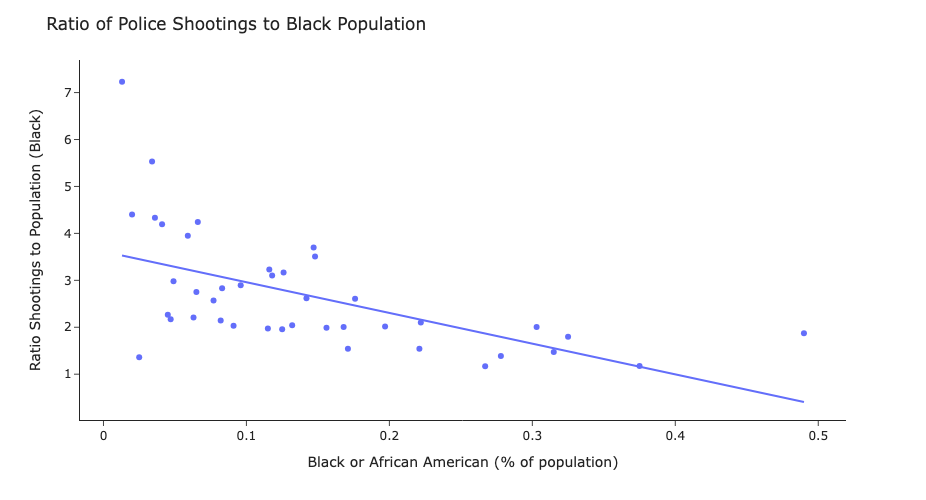

```R² = 0.323```

```p-value = 0.000```

```The relationship is statistically significant.```

In [15]:
x = black_key
y = "Ratio Shootings to Population (Black)"
title = "Ratio of Police Shootings to Black Population"

test_corr_with_chart(proportion_by_race_df,
                     x,
                     y,
                     "Black or African American (% of population)",
                     y,
                     title
                     )

This chart shows the relationship between the proportion of the African American population in a state and by how much are they over-represented as victims of police shootings:
- The states to right have a larger black population (e.g. in Washington DC close to 50%n of all people are black).

- The Y axis show the ratio between the black population in a state and the proportion of victims who are black. e.g. in the topmost state, Utah black people make up only 1.3% of the population but about 7.2% of all victims are black.

While their are over-represented in every state we can conclude from this chart that **the higher proportion of black people live in a state the less likely are they to be shoot**

This finding is quite interesting, while we can just conclusions but one possible explanation is that in areas where black people might make up a higher proportion of of law enforcement agencies they are less likely to be shot than in those where black populations are small.

This would indicate that racial prejudice might be one of the main reasons of this relationship. And that policies specifically targeting states with fewer black people might be beneficial.


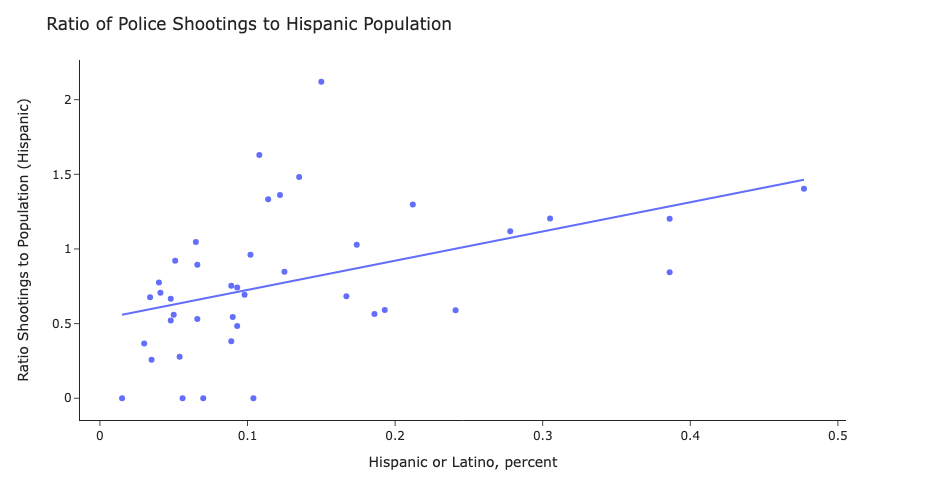

```R² = 0.200```

```p-value = 0.003```

```The relationship is statistically significant.```

In [16]:
x = hispanic_key
y = "Ratio Shootings to Population (Hispanic)"
title = "Ratio of Police Shootings to Hispanic Population"

test_corr_with_chart(proportion_by_race_df,
                     x,
                     y,
                     x,
                     y,
                     title
                     )

Interestingly if we look at Hispanic population the relationship is inverse. The more Hispanic people live in a state there more likely they are to be over-represented. This might indicate the an increase in police shootings might be community related, however this requires further investigation.

In any case the absence of the pattern we've seen with African American indicates that Hispanic people are less likely to be affected by racial prejudice even if in the areas where their population is relatively low.

In [17]:
for_corr_test = df_main[
    ["threat_type", "flee_status", "armed_with", "age", "gender", "race", 'was_mental_illness_related', "body_camera",
     "age_bracket_short", "INC110213"]].copy()
for_corr_test = for_corr_test.infer_objects()

for col in for_corr_test.columns:
    if for_corr_test[col].dtype == 'object':
        for_corr_test[col] = for_corr_test[col].astype('category')
for_corr_test["INC110213"] = for_corr_test["INC110213"].astype("int")

#### 2.4. Armed With and Threat Type

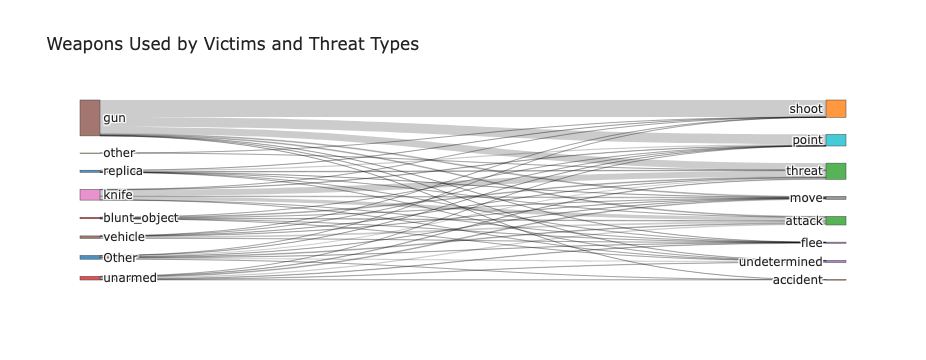

In [18]:
display(Markdown("#### 2.4. Armed With and Threat Type"))

df_threat_temp = df_main[
    ["id",
     "g_threat_type",
     "threat_type",
     "g_armed_with",
     "armed_with", "flee_status", "race", "age", "was_mental_illness_related", "body_camera",
     "gender"]]

df_threat_temp_group = df_threat_temp.groupby(["threat_type", "g_armed_with"]).agg(
    {"id": ["count"]}).reset_index()

categories = ['g_armed_with', 'threat_type']

newDf = pd.DataFrame()
for i in range(len(categories) - 1):
    tempDf = df_threat_temp_group[[categories[i], categories[i + 1], 'id']]
    tempDf.columns = ['source', 'target', 'id']
    newDf = pd.concat([newDf, tempDf])
newDf = newDf.groupby(['source', 'target']).agg({'id': 'sum'}).reset_index()

label_list = list(np.unique(df_threat_temp_group[categories].values))
source = newDf['source'].apply(lambda x: label_list.index(x))
target = newDf['target'].apply(lambda x: label_list.index(x))
count = newDf['id']

fig = go.Figure(data=[go.Sankey(
    node={"label": label_list},
    link={"source": source, "target": target, "value": count}
)])

fig.update_layout(title='Weapons Used by Victims and Threat Types')

render_fig(fig)

In [19]:
def build_race_threat_type_bar_chart(_df: pd.DataFrame, column="threat_type", title="Threat Type Depending on Race"):
    df_threat_temp_group = _df.groupby(["race", column]).agg({"id": ["count"]}).reset_index()

    df_threat_temp_group = df_threat_temp_group.sort_values(("id", "count"), ascending=False)

    def get_prop_race_threat(row):
        race = row["race"].iloc[0]
        sum_race = df_threat_temp_group[df_threat_temp_group["race"] == race]

        sum_race = sum_race[("id", "count")].sum()

        return row[("id", "count")] / sum_race

    df_threat_temp_group["prop"] = df_threat_temp_group.apply(get_prop_race_threat, axis=1)
    x = df_threat_temp_group.race.unique()
    fig = go.Figure()

    for type in df_threat_temp_group[column].unique():

        _df = df_threat_temp_group[df_threat_temp_group[column] == type]
        y = []

        for r in df_threat_temp_group.race.unique():
            t = _df[_df["race"] == r]
            if len(t) > 0:
                y.append(t["prop"].iloc[0])
        fig.add_bar(x=x, y=y, name=str(type), hovertemplate='%{y:.1%}')

    fig.update_layout(barmode="relative", title={
        'text': title,
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    fig.layout.xaxis.fixedrange = True
    fig.layout.yaxis.fixedrange = True

    return fig


# threat_type by Race
df_threat_temp_simplified = df_threat_temp.copy()
df_threat_temp_simplified = df_threat_temp_simplified.dropna(how="any")

include_races = ["White", "Black", "Hispanic"]

df_threat_temp_simplified["race"] = df_threat_temp_simplified["race"].map(
    lambda r: r if r in include_races else "Other")
df_threat_temp_simplified["race"].value_counts(dropna=False)

include_types = ["shoot", "threat", "point", "attack"]
df_threat_temp_simplified["threat_type"] = df_threat_temp_simplified["threat_type"].map(
    lambda r: r if r in include_types else r)

# Black vs others:
df_threat_temp_simplified_black_vs_other = df_threat_temp_simplified.copy()
include_races = ["Black"]
df_threat_temp_simplified_black_vs_other["race"] = df_threat_temp_simplified_black_vs_other["race"].map(
    lambda r: r if r in include_races else "Other")

# Hispanic vs others:
df_threat_temp_simplified_hisp_vs_other = df_threat_temp_simplified.copy()
include_races = ["Hispanic"]
df_threat_temp_simplified_hisp_vs_other["race"] = df_threat_temp_simplified_hisp_vs_other["race"].map(
    lambda r: r if r in include_races else "Other")

In [20]:
df_hypo = df_main[["race", "threat_type", "armed_with", "was_mental_illness_related", "body_camera"]]
df_hypo = df_hypo.dropna(how="any")

df_hypo["is_black"] = df_hypo["race"].map(lambda r: "Black" if r == "Black" else "Other")
df_hypo["is_white"] = df_hypo["race"].map(lambda r: "White" if r == "White" else "Other")
df_hypo["is_hispanic_or_other"] = df_hypo["race"].map(
    lambda r: "Hispanic/Other" if (r != "Black" and r != "White") else "Black/White")

df_hypo["was_unarmed"] = df_hypo["armed_with"].map(lambda t: "Unarmed" if t == "unarmed" else "Other")

df_hypo["is_undetermined"] = df_hypo["threat_type"].map(lambda r: "Undetermined" if r == "undetermined" else "Other")

df_hypo["has_gun"] = df_hypo["armed_with"].map(lambda r: "Gun" if "gun" in r else "Other")

df_hypo["deadly_force"] = df_hypo["threat_type"].map(
    lambda r: "Shoot/Attack" if (r == "shoot" or r == "attack") else "Other")


##### 2.4.1 Threat Type By Race

In this section we'll try to examine the circumstances under the victims we killed and we'll check whether they vary significantly between different races.

Additionally we'll look into whether the relationship between race and the killed individual possessing a firearm or engaging in specific activities is statistically significant.

To do that we'll use the Chi-squared test which is better suited for analyzing association between categorical variables than the Z-Test



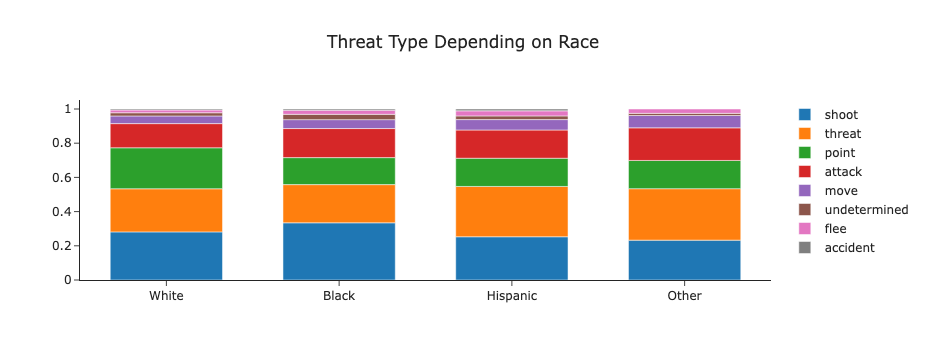

In [21]:
t_1 = build_race_threat_type_bar_chart(df_threat_temp_simplified)
t_2 = build_race_threat_type_bar_chart(df_threat_temp_simplified_black_vs_other, title="Threat Type: Black")
t_3 = build_race_threat_type_bar_chart(df_threat_temp_simplified_hisp_vs_other, title="Threat Type: Hispanic")

render_fig(t_1)

We can see that the reported threat type does indeed vary between races, for instance:


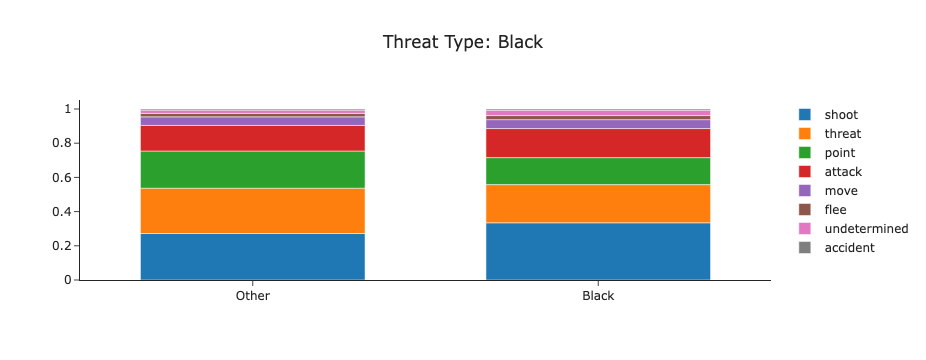

##### Hypothesis 1. Black people are more likely to be killed when after shooting or actively attacking someone than other groups


deadly_force  Other  Shoot/Attack
is_black                         
Black           953           957
Other          3054          2122

Chi2 value: 46.73
P-value: 0.00000
Degrees of freedom: 1.00
Reject null hypothesis: There is a relationship between being black and  being killed while shooting at or actively attack someone.
*alpha = 0.01


In [22]:
render_fig(t_2)

# Hypothesis testing
HYPOTHESIS_1 = "##### Hypothesis 1. Black people are more likely to be killed when after shooting or actively attacking someone than other groups"

contingency_table_1 = pd.crosstab(
    df_hypo['is_black'],
    df_hypo['deadly_force'],
    margins=False
)

display(Markdown(HYPOTHESIS_1))
test_chi_squared(contingency_table_1,
                 reason="between being black and  being killed while shooting at or actively attack someone",
                 alpha=0.01)

It seems that black people are significantly more likely to be shot while shooting a firearm. This is likely an argument against the racial prejudice hypothesis we've expressed previously since shooting is generally the most serious threat and the one most likely to be met with deadly force regardless of the shooter's race.

In [23]:
HYPOTHESIS_4 = "##### Hypothesis 4. Killings of black  are more likely to have no determined reason"

contingency_table_4 = pd.crosstab(
    df_hypo['is_black'],
    df_hypo['is_undetermined'],
    margins=False
)

display(Markdown(HYPOTHESIS_4))
test_chi_squared(contingency_table_4, reason="between undetermined threat type and victim being black")

##### Hypothesis 4. Killings of black  are more likely to have no determined reason


is_undetermined  Other  Undetermined
is_black                            
Black             1836            74
Other             5019           157

Chi2 value: 2.87
P-value: 0.09031
Degrees of freedom: 1.00
Fail to reject null hypothesis: There is no relationship between undetermined threat type and victim being black.
*alpha = 0.05


In the main chart we've noticed that there are slighly more incidents where black people were shot but there was no reported threat type compared to other races. However this does not appear to be significant, but it might be worth examining it further as it likely indicates that these people might have been shot without sufficient cause.

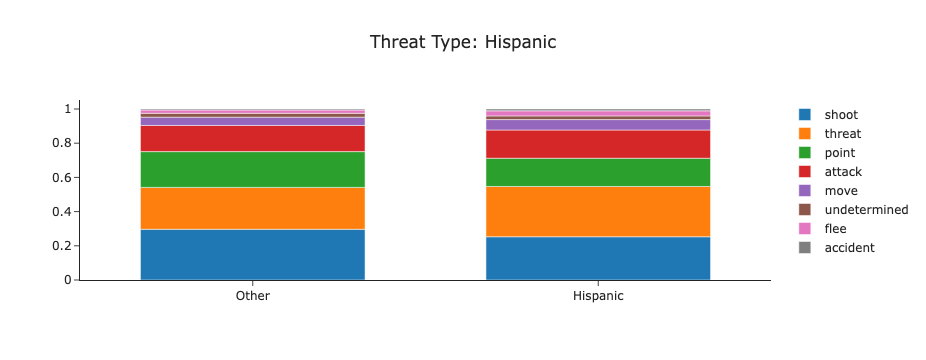

##### Hypothesis 2. Hispanic and other people are more likely to be killed when not armed with a firearm than black or white people


has_gun                Gun  Other
is_hispanic_or_other             
Black/White           3470   2074
Hispanic/Other         815    727

Chi2 value: 47.44
P-value: 0.00000
Degrees of freedom: 1.00
Reject null hypothesis: There is a relationship between being hispanic and not being armed with a firearm when killed.
*alpha = 0.01


In [24]:
render_fig(t_3)

# Hypothesis testing
HYPOTHESIS_2 = "##### Hypothesis 2. Hispanic and other people are more likely to be killed when not armed with a firearm than black or white people"

contingency_table_2 = pd.crosstab(
    df_hypo['is_hispanic_or_other'],
    df_hypo['has_gun'],
    margins=False
)

display(Markdown(HYPOTHESIS_2))
test_chi_squared(contingency_table_2, reason="between being hispanic and not being armed with a firearm when killed",
                 alpha=0.01)

Another interesting observation is that hispanic people are less likely to be firing a gun when shot. This also something which should be investigated further.


#####  2.4.2 Armed With By Race

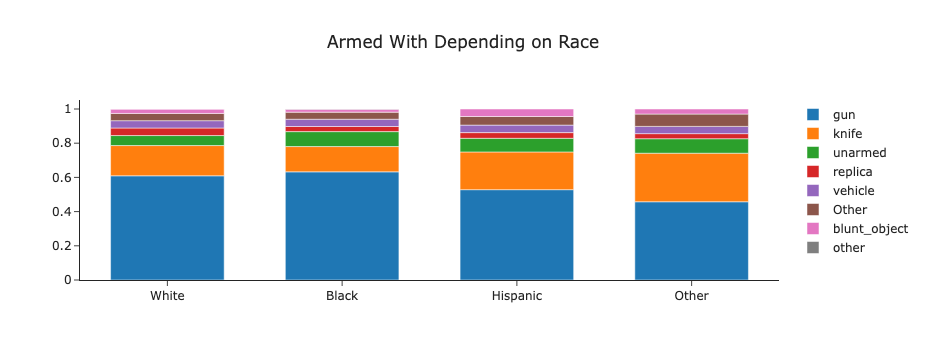

##### Hypothesis 6. Non-white people are significantly more likely to be killed when unarmed


was_unarmed  Other  Unarmed
is_white                   
Other         3178      274
White         3434      200

Chi2 value: 16.41
P-value: 0.00005
Degrees of freedom: 1.00
Reject null hypothesis: There is a relationship between the killed individual being unarmed and non-white.
*alpha = 0.01


In [25]:
display(Markdown("#####  2.4.2 Armed With By Race"))

a_1 = build_race_threat_type_bar_chart(df_threat_temp_simplified, column="g_armed_with",
                                       title="Armed With Depending on Race")
a_2 = build_race_threat_type_bar_chart(df_threat_temp_simplified_black_vs_other, column="g_armed_with",
                                       title="Armed With: Black")
a_3 = build_race_threat_type_bar_chart(df_threat_temp_simplified_hisp_vs_other, column="g_armed_with",
                                       title="Armed With: Hispanic")

render_fig(a_1)

HYPOTHESIS_6 = "##### Hypothesis 6. Non-white people are significantly more likely to be killed when unarmed"

contingency_table_6 = pd.crosstab(
    df_hypo['is_white'],
    df_hypo['was_unarmed'],
    margins=False
)

display(Markdown(HYPOTHESIS_6))
test_chi_squared(contingency_table_6, reason="between the killed individual being unarmed and non-white", alpha=0.01)

This suggests that police officers are less likely to shot white people unless they are carrying some sort of a weapon. This is a fairly clear indication of racial prejudice and possibly means that policemen might put in more effort in defusing the situation before using deadly force if white people are involved.

However since the number of incidence is fairly low we can't say this occurs in a significant proportion of police shootings.

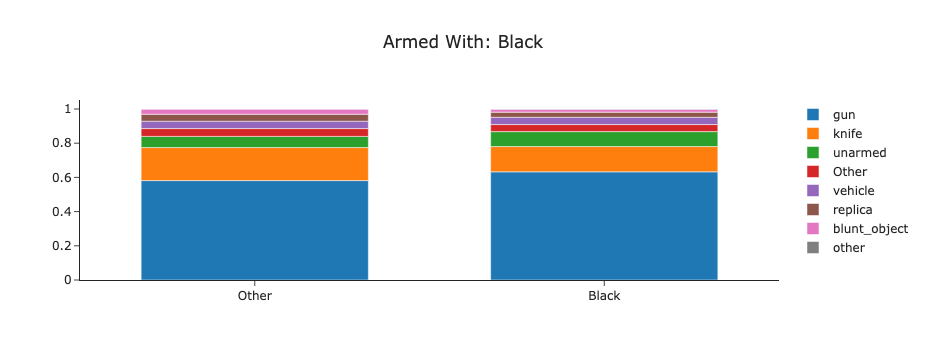

In [26]:
render_fig(a_2)

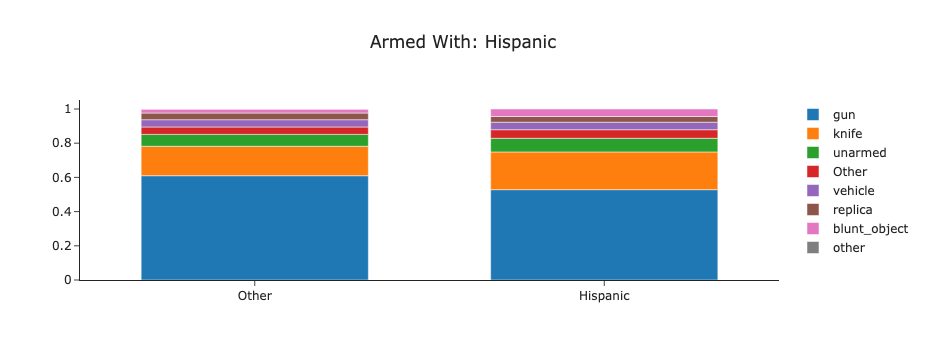

In [27]:
render_fig(a_3)

The fact that Hispanic people are more likely to be shot while not firing a gun seems to be mostly explained by them being more likely to have knives. 

#### 2.5 Flee Status

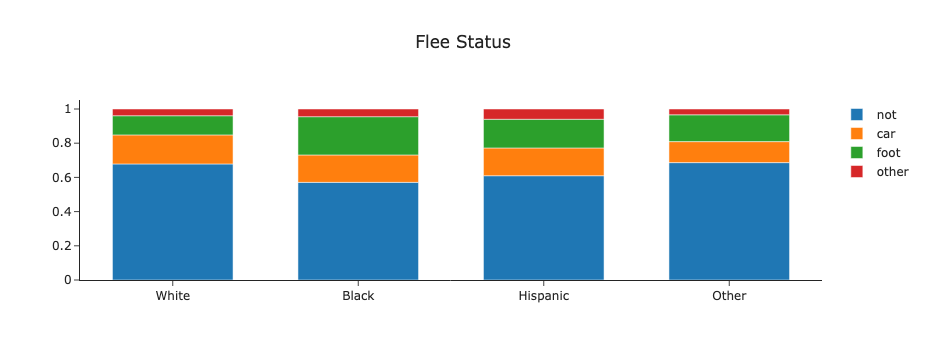

In [28]:
display(Markdown("#### 2.5 Flee Status"))

f_1 = build_race_threat_type_bar_chart(df_threat_temp_simplified, column="flee_status", title="Flee Status")
render_fig(f_1)

It seems that Hispanic and black people are more likely to be shot when fleeing than other people. Without additional data we can't really speculate on the reasons of this too much.

Either police officers are more likely to use deadly force when the fleeing individual is white or white people are less likely to flee (.e.g. significantly more shootings of white people seem to be mental illness related and such individual are possibly less likely to attempt to run away).

#### 2.6. Mental Ilness Related Shootings

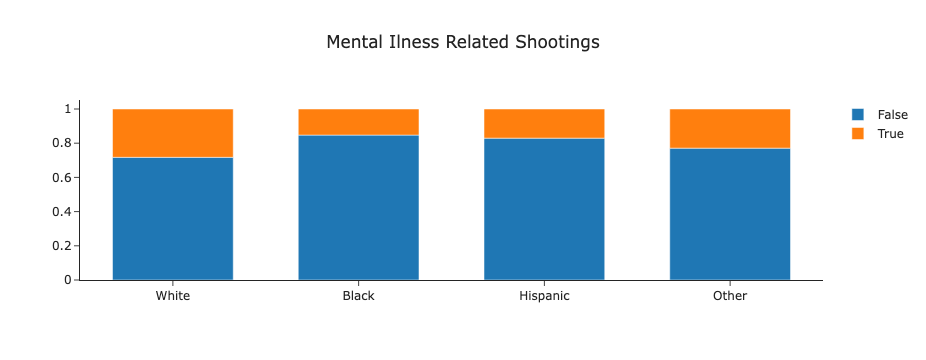

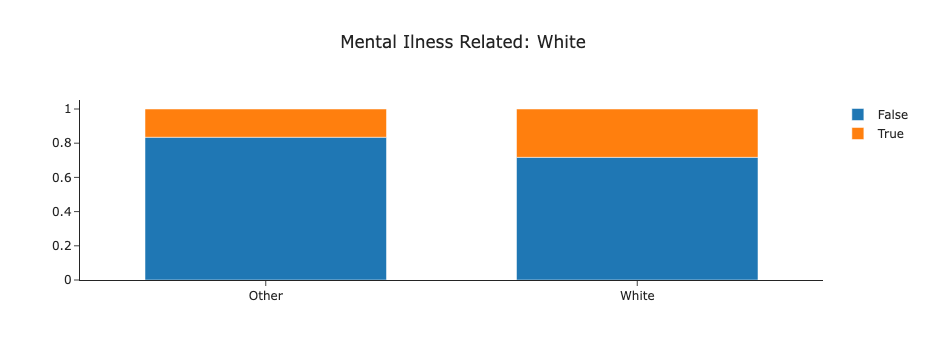

##### Hypothesis 3. Killings of white individuals are more likely to be related to mental health issues


was_mental_illness_related  False  True 
is_white                                
Other                        2890    562
White                        2642    992

Chi2 value: 124.87
P-value: 0.00000
Degrees of freedom: 1.00
Reject null hypothesis: There is a relationship between being white and the killing being mental health related.
*alpha = 0.01


In [29]:
display(Markdown("#### 2.6. Mental Ilness Related Shootings"))
f_1 = build_race_threat_type_bar_chart(df_threat_temp_simplified, column="was_mental_illness_related",
                                       title="Mental Ilness Related Shootings")

render_fig(f_1)

df_mental_ill_simplified_white_vs_other = df_threat_temp_simplified.copy()
include_races = ["White"]
df_mental_ill_simplified_white_vs_other["race"] = df_mental_ill_simplified_white_vs_other["race"].map(
    lambda r: r if r in include_races else "Other")

f_2 = build_race_threat_type_bar_chart(df_mental_ill_simplified_white_vs_other,
                                       column="was_mental_illness_related",
                                       title="Mental Ilness Related: White")
render_fig(f_2)

HYPOTHESIS_3 = "##### Hypothesis 3. Killings of white individuals are more likely to be related to mental health issues"

contingency_table_3 = pd.crosstab(
    df_hypo['is_white'],
    df_hypo['was_mental_illness_related'],
    margins=False
)
display(Markdown(HYPOTHESIS_3))
test_chi_squared(contingency_table_3, reason="between being white and the killing being mental health related",
                 alpha=0.01)

Without additional data this is relatively hard to interpret. More straightforward explanation would be that white people are less likely to be killed while committed intentional/deliberate property related or other violent crimes. This might be developed further using additional crime statistics datasets (if available)

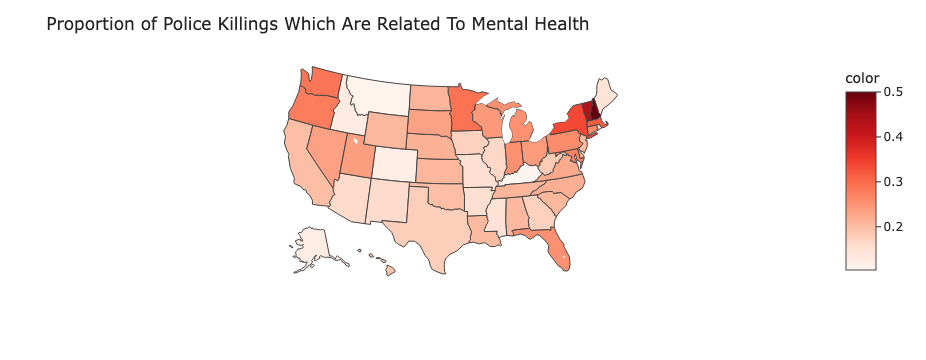

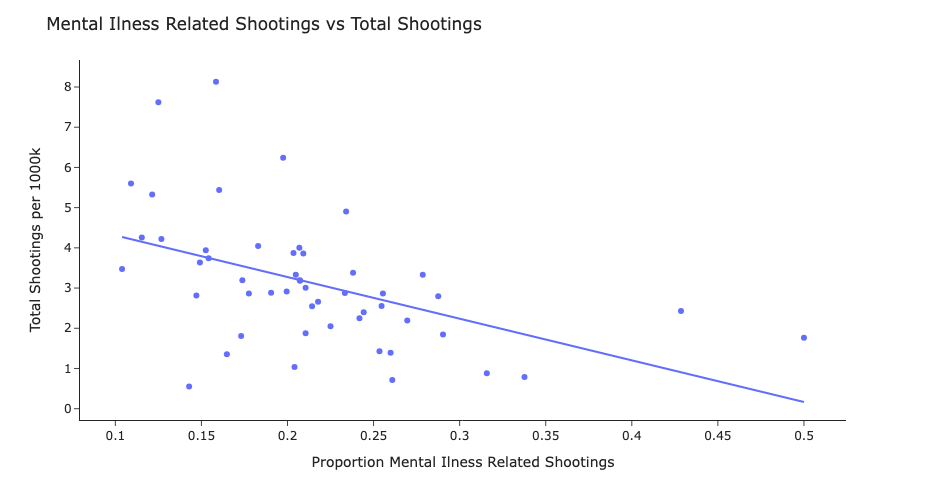

```R² = 0.230```

```p-value = 0.000```

```The relationship is statistically significant.```

In [30]:
# Geographic distribution of shootings related to mental ilness
was_mental_illness_related_geo_df = df_main.groupby(by=["state"]).agg(
    count=('id', 'count'),
    was_mental_illness_related=('was_mental_illness_related', 'sum')
).reset_index().set_index("state")

was_mental_illness_related_geo_df["was_mental_illness_related_geo_df_prop"] = was_mental_illness_related_geo_df[
                                                                                  "was_mental_illness_related"] / \
                                                                              was_mental_illness_related_geo_df["count"]

states = list(was_mental_illness_related_geo_df.index)
proportions = list(was_mental_illness_related_geo_df["was_mental_illness_related_geo_df_prop"])

was_mental_illness_related_geo_df = was_mental_illness_related_geo_df.merge(
    by_state_df.set_index("state")["All per 1000k"],
    how="left",
    left_index=True,
    right_index=True)

hover_texts = [f"State: {state}<br>Value: {prop:.2%}" for state, prop in zip(states, proportions)]

fig = px.choropleth(
    locations=was_mental_illness_related_geo_df.index,
    locationmode="USA-states",
    color=was_mental_illness_related_geo_df["was_mental_illness_related_geo_df_prop"],
    color_continuous_scale="reds",
    scope="usa",
    custom_data=[was_mental_illness_related_geo_df.index,
                 was_mental_illness_related_geo_df['was_mental_illness_related_geo_df_prop'] * 100]
)
fig.update_traces(
    hovertemplate='State: %{customdata[0]}<br>Value: %{customdata[1]:.2f}%<extra></extra>'
)

fig.update_layout(title='Proportion of Police Killings Which Are Related To Mental Health')
fig.layout.dragmode = False
fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True
render_fig(fig)
was_mental_illness_related_geo_df

x = "was_mental_illness_related_geo_df_prop"
y = "All per 1000k"
title = "Mental Ilness Related Shootings vs Total Shootings"

test_corr_with_chart(was_mental_illness_related_geo_df,
                     x,
                     y,
                     "Proportion Mental Ilness Related Shootings",
                     "Total Shootings per 1000k",
                     title
                     )

The proportion of shootings that were related to mental health issues seems to vary wildly between different states. The situation in some of the North-Eastern states seems to be the worst.

However we shouldn't just jump to conclusions. If we look at the relationship between the total number of police shootings and what proportion of them were related we can see that while the correlation is not very strong the proportion of of shootings related to mental health increases as the overall number of shootings in a state decreases.

The most intuitive explanation of that is that mental health related shootings in states like New York (which have very low number of shootings overall) are not necessarily a bigger issue than in other states but that people in other states are much more likely to be shot for different reasons.

However we can still compare states with overall comparable numbers of police shootings, for example:
- Maine, Washington, Vermont and New Hampshire have comparable rates of police shootings, but close to 50% of all shootings in Maine are mental health related while only 15% in Maine are (with the other states in between). Barring reporting issues and considering how similar in most aspects these states are (so it's unlikely the overall prevalence of mental health issues might be very different) government in New Hampshire (and other states in comparable situations) should consider adopting the mental health related policies which are used in states like Maine.

**Significant variance between the proportion of mental health related police killings in states with similar overall number of shootings indicates that the law enforcement agencies and/or public health departments should try to adopt the best practices used in other states**

#### 2.7 Age Analysis

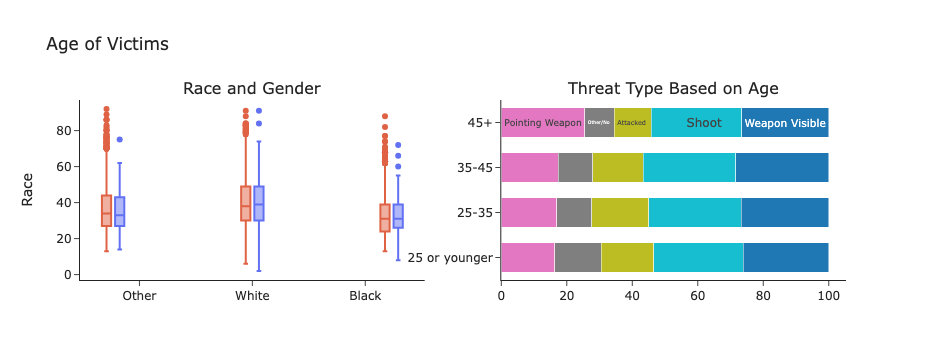

In [31]:
display(Markdown("#### 2.7 Age Analysis"))

fig = make_subplots(rows=1, cols=2, subplot_titles=("Race and Gender", "Threat Type Based on Age"))

EXCLUDE_SMALL_GROUPS_THRESHOLD = 25

# Iterate through the unique combinations of race and gender
for race in df_main['g_race_short'].unique():
    for gender in df_main['gender'].unique():
        subgroup = df_main[(df_main['g_race_short'] == race) & (df_main['gender'] == gender)]

        # If the number of observations is less than 50, create a scatter plot
        if len(subgroup) < 50:
            if len(subgroup) < EXCLUDE_SMALL_GROUPS_THRESHOLD:
                pass
            else:
                fig.add_trace(go.Box(

                    x=subgroup['g_race_short'],
                    y=subgroup['age'],
                    boxpoints='all',  # Show all points
                    jitter=0.3,  # Add jitter to the points for better visibility
                    pointpos=-1.8,  # Position of the points relative to the box
                    name=f'{race}-{gender}',
                    marker=dict(color='blue' if gender == 'male' else 'red'),
                    boxmean=False,  # Hide the mean line
                    line=dict(color='rgba(0,0,0,0)')  # Hide the box by making it transparent
                ))
                x_jitter = np.random.uniform(-0.1, 0.1, len(subgroup))

                fig.add_trace(go.Scatter(
                    x=subgroup['race'] + x_jitter,
                    y=subgroup['age'],
                    mode='markers',
                    name=f'{race}-{gender}',
                    marker=dict(color='blue' if gender == 'male' else 'red')
                ))
        # Otherwise, create a box plot
        else:
            fig.add_trace(go.Box(
                x=subgroup['g_race_short'],
                y=subgroup['age'],
                showlegend=False,
                name=f'{race}-{gender}',
                marker=dict(color=COLOR_PRIMARY_RED if gender == 'male' else COLOR_PRIMARY_BLUE)
            ), row=1, col=1)

grouped = df_main.groupby(['age_bracket_short', 'g_threat_type']).size().reset_index(name='counts')
total_counts = grouped.groupby('age_bracket_short')['counts'].sum().reset_index(name='total_counts')
grouped = grouped.merge(total_counts, on='age_bracket_short', how='left')
grouped['relative_counts'] = grouped['counts'] / grouped['total_counts'] * 100

event_types = df_main['g_threat_type'].unique()

for idx, event_type in enumerate(event_types):
    filtered_group = grouped[grouped['g_threat_type'] == event_type]

    text_labels = [None for x in filtered_group['age_bracket_short'].unique()]
    text_labels[-1] = event_type.ljust(9)

    fig.add_trace(go.Bar(
        orientation='h',
        showlegend=False,
        hovertemplate='%{x:.1f}%',
        textposition='inside',
        y=filtered_group['age_bracket_short'],
        x=filtered_group['relative_counts'],
        name=event_type,
        text=text_labels,  # Add labels for the first event type

    ), row=1, col=2)

fig.update_layout(
    title_text=('Age of Victims'),
    barmode='stack',
    yaxis_title='Race',
    boxmode='group'  # group together boxes of the different traces for each value of x
)

render_fig(fig)

Victims who are white generally tend to be older (median: 39 years) than those who are black (31) or are Hispanic and other (34).
However this mostly corresponds to the the difference in median age in the overall population:

- White 44 years
- Black 35 years
- Hispanic 30 years

We can also see that shooting victims tend to be a bit younger than the rest of the population.

There seems to be no meaningful difference in age between genders.

Looking at the threat type we can see that older people are much more likely to be shot while point a weapon while younger people are more often shot while physically attacking someone which seems to be fairly self explanatory.

It doesn't seem that we can make any meaningful conclusions based on this.

#### 2.9 Body Camera Usage

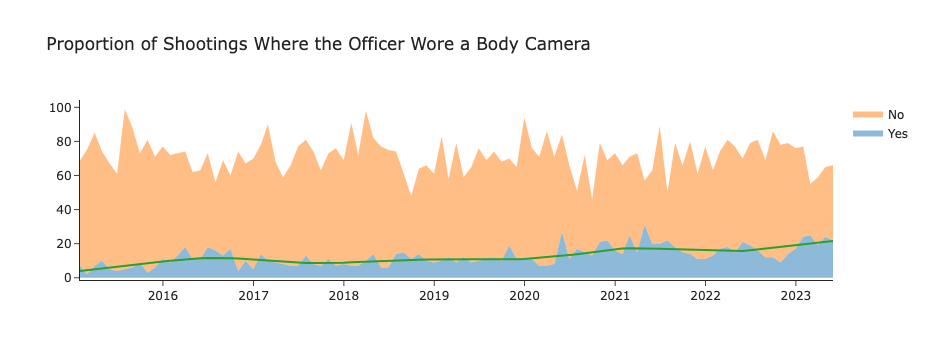

Intuitively we could expect that increasing usgae of body cameras would've resultedin a decrease of police shootings, however this has not been the case.There are several possible explanations for that:

- Body cameras are being rolled out at a too slow pace. Any effect they might have hadhas been overshadowed by increasing police killings (possible related to the covid pandemic

- There is no meaningful relationship because camera usage and shootings or it's very low

We can't measure this relationship statistically without additional data such as a dataset of all police encounters and their outcomes which is obviously unobtainable.There possibly might be other approaches that could be used to estimate the effect bodycameras have which might be worth investigating 

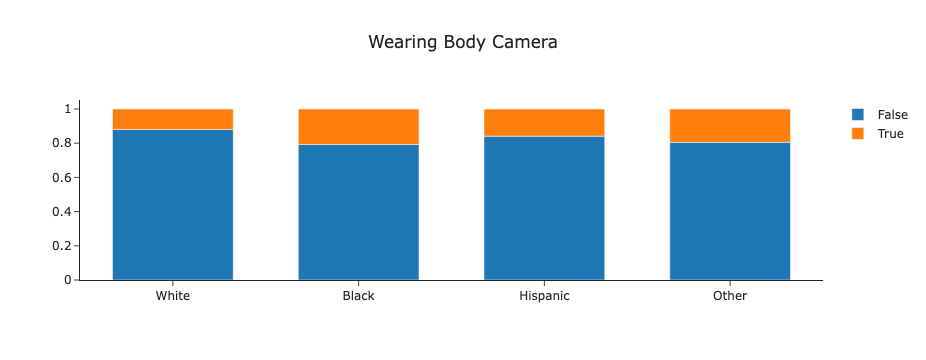

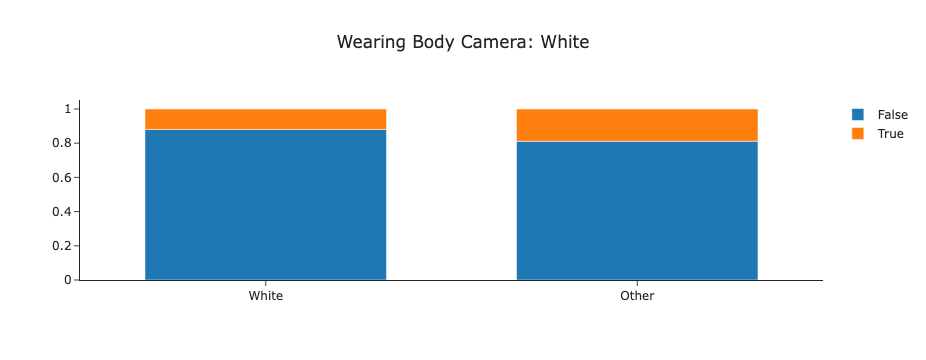

##### Hypothesis 5. White people are significantly less likely to be killed when the officer is wearing a body camera


body_camera  False  True 
is_white                 
Other         2805    647
White         3195    439

Chi2 value: 60.04
P-value: 0.00000
Degrees of freedom: 1.00
Reject null hypothesis: There is a relationship between the killed individual being white and the officer wearing a body camera.
*alpha = 0.01


In [32]:
display(Markdown("#### 2.9 Body Camera Usage"))

body_cam_ts_df = df_main.resample(rule='M', on='date').agg(
    count=('id', 'count'),
    Yes=('body_camera', 'sum')
).reset_index()
body_cam_ts_df["No"] = body_cam_ts_df["count"] - body_cam_ts_df["Yes"]
body_cam_ts_df
# Drop last two months, not all data available
body_cam_ts_df = body_cam_ts_df[(body_cam_ts_df['date'] < "2023-06-01")]

fig = go.Figure()

body_cam_prop = body_cam_ts_df["Yes"] / body_cam_ts_df["count"]
hover_template = ['<b>Prop. Wearing: {}%</b>'.format(round(h * 100, 1)) for h in body_cam_prop.tolist()]

fig.add_trace(go.Scatter(x=body_cam_ts_df.date,
                         name="Yes",
                         hovertemplate=hover_template,

                         y=body_cam_ts_df.Yes, fill='tozeroy',
                         mode='none'  # override default markers+lines
                         ))

hover_template = ['<b>Total: %s</b>' % h for h in body_cam_ts_df["count"].tolist()]

fig.add_trace(go.Scatter(x=body_cam_ts_df.date,
                         y=body_cam_ts_df.No,
                         hovertemplate=hover_template,
                         name="No",
                         fill='tonexty',
                         mode='none'))

# Add a trendline for camera wearing
smoothed = lowess(body_cam_ts_df["Yes"], body_cam_ts_df.index, frac=0.25)
#
trendline_trace = go.Scatter(x=smoothed[:, 0], y=smoothed[:, 1], mode='lines',
                             showlegend=False,
                             name='LOWESS Trendline',
                             xaxis='x2',
                             hoverinfo='none'
                             )
fig.add_trace(trendline_trace)

fig.update_layout(
    xaxis2=dict(
        showticklabels=False,
        domain=[0.6, 0.95],  # You can adjust the domain to position the secondary x-axis
        anchor='y',
        ticks='',
        overlaying='x',
        # title='Secondary X Axis'
    ),
    title="Proportion of Shootings Where the Officer Wore a Body Camera",
    dragmode=False,
    xaxis=dict(
        fixedrange=True
    ),
    yaxis=dict(
        fixedrange=True
    )
)

# fig.show(config={'displayModeBar': False})
render_fig(fig)

display(Markdown("Intuitively we could expect that increasing usgae of body cameras would've resulted"
                 "in a decrease of police shootings, however this has not been the case."
                 "There are several possible explanations for that:"))

display(Markdown("- Body cameras are being rolled out at a too slow pace. Any effect they might have had"
                 "has been overshadowed by increasing police killings (possible related to the covid pandemic"))

display(Markdown("- There is no meaningful relationship because camera usage and shootings or it's very low"))

display(Markdown(""))
display(Markdown("We can't measure this relationship statistically without additional data such as "
                 "a dataset of all police encounters and their outcomes which is obviously unobtainable."
                 "There possibly might be other approaches that could be used to estimate the effect body"
                 "cameras have which might be worth investigating "))

f_1 = build_race_threat_type_bar_chart(df_threat_temp_simplified,
                                       column="body_camera",
                                       title="Wearing Body Camera")

f_2 = build_race_threat_type_bar_chart(df_mental_ill_simplified_white_vs_other,
                                       column="body_camera",
                                       title="Wearing Body Camera: White")

render_fig(f_1)
render_fig(f_2)
HYPOTHESIS_5 = "##### Hypothesis 5. White people are significantly less likely to be killed when the officer is wearing a body camera"

contingency_table_5 = pd.crosstab(
    df_hypo['is_white'],
    df_hypo['body_camera'],
    margins=False
)

display(Markdown(HYPOTHESIS_5))
test_chi_squared(contingency_table_5,
                 reason="between the killed individual being white and the officer wearing a body camera", alpha=0.01)

In [33]:
CHECK_CORRELATION_PAIRS = False

if CHECK_CORRELATION_PAIRS:
    df_dummies = pd.get_dummies(for_corr_test)

    # Compute the correlation matrix
    corr_matrix = df_dummies.corr(method="spearman")

    # Find pairs with correlation above 0.4 or below -0.4
    pairs_with_corr = [(col1, col2, corr_matrix[col1][col2]) for col1 in corr_matrix.columns for col2 in
                       corr_matrix.index
                       if (col1 != col2) and (corr_matrix[col1][col2] > 0.4 or corr_matrix[col1][col2] < -0.4)]

    # Removing duplicates
    pairs_with_corr = set(tuple(sorted((pair[0], pair[1])) + [pair[2], ]) for pair in pairs_with_corr)

    corr_res = []

    for pair in pairs_with_corr:
        corr_res.append({"var I": pair[0], "var II": pair[1], "coef": f"{pair[2]:.2f}"})

    display(Markdown("#### 1.2.10 Correlations"))

    display(Markdown("Variables pairs with Spearman corr. bellow -0.4 or above 0.4:"))
    pd.DataFrame(corr_res)

### 1.3 Analysis

After examining the dataset and performing some basic hypothesis testing we've found that there are some significant differences between the characteristics of victims depending on their race and age:

- Black people are more likely to be killed when after shooting or actively attacking someone than other group
- Hispanic and other people are more likely to be killed when not armed with a firearm than black or white people
- Killings of white individuals are more likely to be related to mental health issues
- Killings of black people are more likely to have no determined reason than for other groups
- White people are significantly less likely to be killed when the officer is wearing a body camera
- Non-white people are significantly more likely to be killed when unarmed
- People who are 45 or older are more likely to be killed while pointing a firearm

However we can't explain whether these relationships exist due to some underlying reason (e.g. systemic discrimination or  biases of the law enforcement agents, socioeconomic differences between racial groups etc.) without additional data. This is something that needs to be investigated further.

However even if we were able to provide a more reliable explanation for these relationships that does not mean that we will be able to derive actionable decisions for the United States Department of Justice. Solving them might require an enactment of complex socioeconomic policies which is not something the state department is in control.

One other important aspect that we must take into account is that while all police shootings are regrettable the majority of them are justifiable in the sense that the victim was shot while committing a violent crime and threatening the life and safety of other individuals and/or police officers.

While it's possibly that the prior training etc. of police officers to handle such situations using less lethal methods can possibly decrease the number of deaths this is not something wen can analyze using the data we have.

Instead we'll focus on demographic, social, economic and other macro factors which can be used to explain the varying levels of police shootings between different states to:
    1. Determine the factors which explain the variance in police shootings.
    2. Find factors which can be influenced by Federal and local governments.

This might allow police departments in different states to adopt policies, training standards etc. from other jurisdictions which is potentially a relatively straightforward way to decrease the incidence of police shootings.

### 3. Explaining Differences Between States:

One possible approach could be to try and find demographically similar US states which have significantly different numbers of shootings per capita. If such states exist we can try to find whether this can be explained by some other variable or attribute which could be theoretically influenced by local or state governments.

In [34]:

state_per_capita_df = by_state_df.set_index("state")[["All", "Black", "White", "Hispanic",
                                                      "All per 1000k",
                                                      "White per 1000k",
                                                      "Black per 1000k",
                                                      "Hispanic per 1000k",
                                                      "Native American per 1000k"]].reset_index().set_index("state")
by_state_df_with_facts = get_facts_df_readable(df_facts_state.rename_axis("state"))
by_state_df_with_facts = by_state_df_with_facts.merge(right_index=True, left_index=True, how="left",
                                                      right=state_per_capita_df)
by_state_df_with_facts = by_state_df_with_facts.merge(right_index=True,
                                                      left_index=True,
                                                      how="left",
                                                      right=state_spending[["Police"]])

# Drop DC because of low data and being a huge outlier in everything
# See hierarchical clustering with it included..
# by_state_df_with_facts = by_state_df_with_facts[by_state_df_with_facts["state"] != "DC"]
by_state_df_with_facts = by_state_df_with_facts.drop(columns=["area_name", "fips", "state"])

by_state_df_with_facts = by_state_df_with_facts.apply(pd.to_numeric)

by_state_df_with_facts["police_prop_income"] = by_state_df_with_facts["Police"] / by_state_df_with_facts[
    "Per capita money income in past 12 months (2013 dollars)"]

#### 3.1. Homocide Rates

We would expect the the number of police shootings would be more or less proportional to the levels of violent crime in any given state:

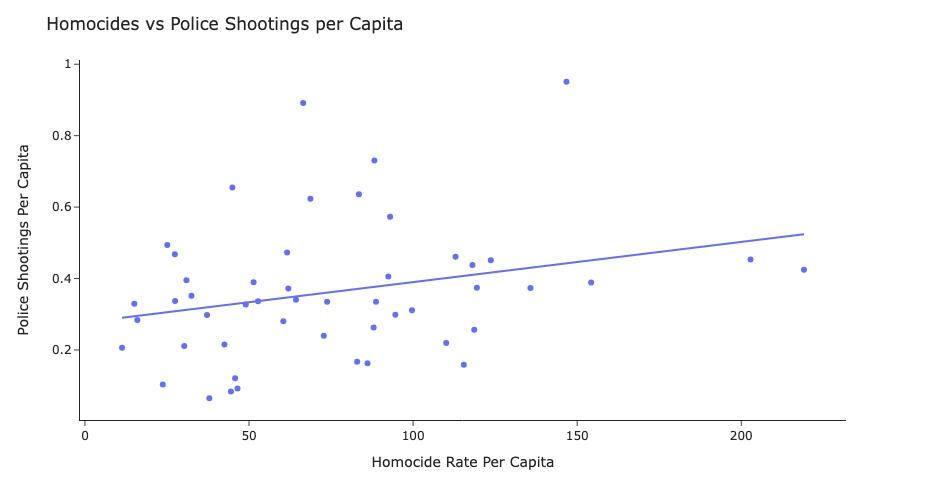

```R² = 0.074```

```p-value = 0.056```

```The relationship is not statistically significant.```

In [35]:
display(Markdown("#### 3.1. Homocide Rates"))

display(Markdown("We would expect the the number of police shootings would be more or less" +
                 " proportional to the levels of violent crime in any given state:"))

x = "Homocide per 1000k"
y = "All per 1000k"
x_label = "Homocide Rate Per Capita"
y_label = "Police Shootings Per Capita"

title = "Homocides vs Police Shootings per Capita"
temp_df = by_state_df_with_facts[[x, y]].dropna()
temp_df[y] = temp_df[y] / TOTAL_YEARS_IN_DF

test_corr_with_chart(temp_df, x, y, x_label, y_label, title)

Interestingly we can see that the correlation between the homicide and police shootings is very low and only a small proportion of variability in police shootings between different states can be explained.

**While this insight on it's does suggest provide any specific actionable decisions it indicates high numbers of police shootings can't be justified by the prevalence of violent crime alone. This is very concerning since it indicates that a high proportion of police shootings can't be justified and it's likely an outcome of flaws is law enforcement policies, training etc. which is something that should be adressed**

##### 1.3.1.2 Police Spending Per Capita

Next let look at the spending on law enforcment per capita (adjusted by per capita income in state):

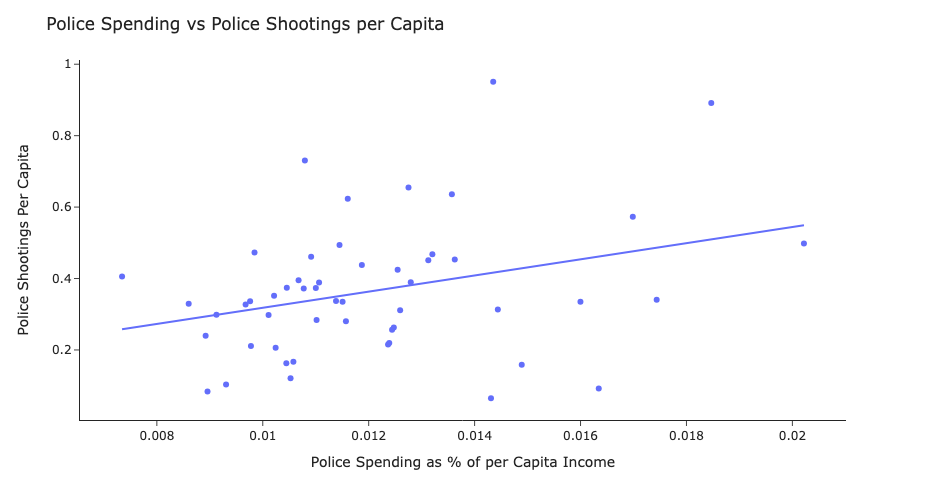

```R² = 0.101```

```p-value = 0.022```

```The relationship is statistically significant.```

In [36]:
display(Markdown("##### 1.3.1.2 Police Spending Per Capita"))

display(
    Markdown("Next let look at the spending on law enforcment per capita (adjusted by per capita income in state):"))

x = "police_prop_income"
y = "All per 1000k"
x_label = "Police Spending as % of per Capita Income"
y_label = "Police Shootings Per Capita"
title = "Police Spending vs Police Shootings per Capita"
temp_df = by_state_df_with_facts[[x, y]].dropna()
temp_df[y] = temp_df[y] / TOTAL_YEARS_IN_DF

test_corr_with_chart(temp_df, x, y, x_label, y_label, title)

While relationship between high spending on law enforcement and the number of police shootings is relatively weak, surprisingly it's positively correlated and statistically significant. **The more a state spends on police the more people end up being shot**. We shouldn't just took conclusions based on this alone, though. It's possible that there are other factors at play:
- There is more crime in poorer states requiring more resources for law enforcement (however we have already partially disproved this by looking at the homicide rate)"))
- Types of homocides/violent crime (i.e. high levels of drug or organized crime related crime probably require more resources to police than high levels of domestic and low level crime)
 - Other socio-demographic variables which are possibly correlated with police spending (e.g. population density) offer a stronger explanation"))
 - allocation of spending (i.e. in some states police officers might be expected to provide services which might be provided by other organization in other states"))
etc."))

**While decreasing police budgets outright it probably not a good solution the Justice Department and local agencies should look into whether the allocation of fund is efficient and whether high policy presence in some parts of the country are fully justifiable.** 

In [37]:
display(Markdown("##### 1.3.1.1 Clustering States by Demographics"))

# Enable commented out variables to include them into the analysis+
demo_vars = [
    'Persons 65 years and over, percent',
    'White alone, percent',
    'Black or African American alone, percent',
    # 'American Indian and Alaska Native alone, percent',
    # 'Asian alone, percent',
    'Hispanic or Latino, percent',
    'Foreign born persons, percent',
    'Language other than English spoken at home, pct age 5+',
    'High school graduate or higher, percent of persons age 25+',
    "Bachelor's degree or higher, percent of persons age 25+",
    'Homeownership rate',
    'Housing units in multi-unit structures, percent',
    # 'Median value of owner-occupied housing units',
    # 'Persons per household',
    'Median household income',
    'Persons below poverty level, percent',
    'Population per square mile, 2010',
    "police_prop_income",
    "Homocide per 1000k"
]

demo_clusters_df = by_state_df_with_facts[demo_vars]
demo_clusters_df["home_price_to_income"] = \
    by_state_df_with_facts["Median value of owner-occupied housing units"] / by_state_df_with_facts[
        "Median household income"]

##### 1.3.1.1 Clustering States by Demographics

In [38]:
demo_clusters_df = demo_clusters_df.dropna()

by_state_df_with_facts_cluster_df = by_state_df_with_facts.loc[demo_clusters_df.index]

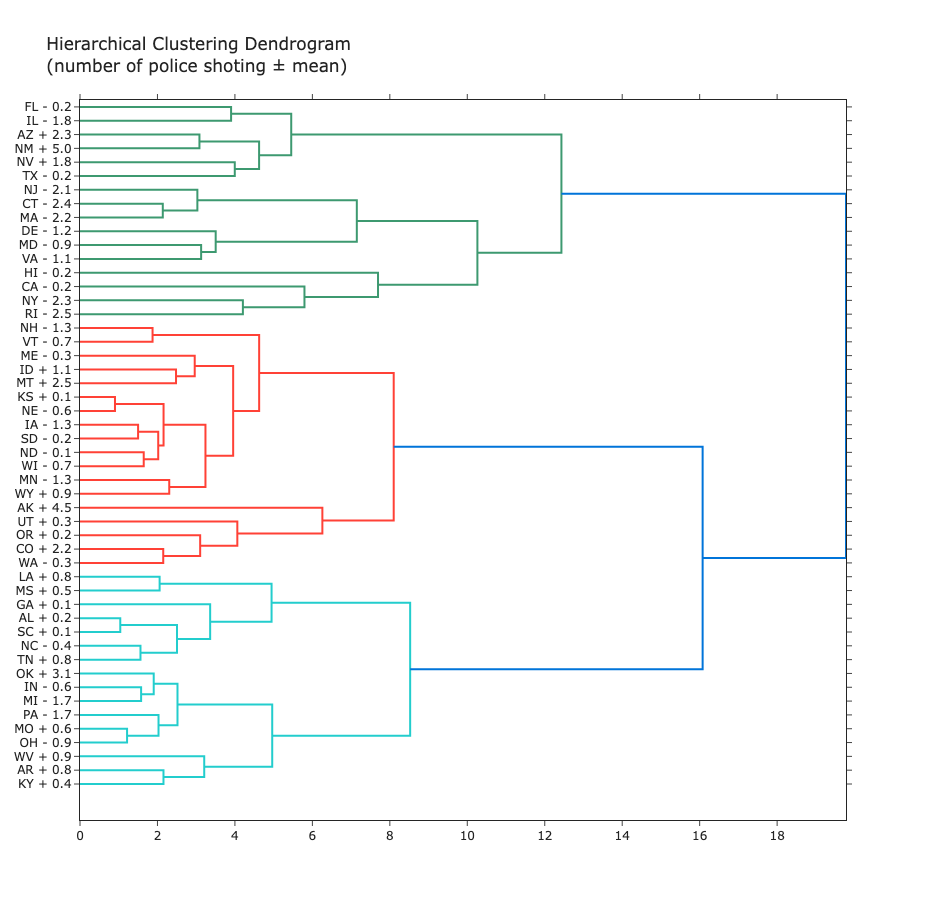

Hierarchical clustering is a method of cluster analysis that builds a hierarchy ofclusters by minimizing the variance of thedistances between the clusters being merged.

The states that end up on the same branch are most similar to each other based on these factors:

 - Persons 65 years and over, percent

 - White alone, percent

 - Black or African American alone, percent

 - Hispanic or Latino, percent

 - Foreign born persons, percent

 - Language other than English spoken at home, pct age 5+

 - High school graduate or higher, percent of persons age 25+

 - Bachelor's degree or higher, percent of persons age 25+

 - Homeownership rate

 - Housing units in multi-unit structures, percent

 - Median household income

 - Persons below poverty level, percent

 - Population per square mile, 2010

 - police_prop_income

 - Homocide per 1000k

In [39]:
# Hierarchical Clustering
warnings.filterwarnings('ignore')

h_cluster_df = demo_clusters_df.copy()
h_cluster_df = h_cluster_df.apply(pd.to_numeric)

per_1000k_mean = by_state_df_with_facts_cluster_df["All per 1000k"].mean()


def get_label(row):
    diff = row["All per 1000k"] - per_1000k_mean
    return f'{row.name} {"+" if diff > 0 else "-"} {abs(diff):.1f}'


labels = by_state_df_with_facts_cluster_df.apply(get_label, axis=1)

# whiten the values which is a process of rescaling data to a standard deviation of 1
scaled_data = whiten(h_cluster_df.to_numpy())

# Use Plotly's create_dendrogram for visualization
fig = ff.create_dendrogram(scaled_data,
                           orientation='left',
                           labels=labels,
                           linkagefun=lambda x: linkage(scaled_data, method='ward', metric='euclidean'))

# Update the layout as desired
fig.update_layout(width=500, height=900,
                  title='Hierarchical Clustering Dendrogram<br>(number of police shoting ± mean)')
render_fig(fig)

display(Markdown("Hierarchical clustering is a method of cluster analysis that builds a hierarchy of"
                 + "clusters by minimizing the variance of the" +
                 "distances between the clusters being merged."))

display(Markdown("The states that end up on the same branch are most similar to each other based on these factors:"))
for v in demo_vars:
    display(Markdown(f" - {v}"))

warnings.filterwarnings('default')

We need to find a threshold at which we'll have a reasonable number of clusters.  In addition to relying on the Dendogram we can also measure ther Silhouette Score:

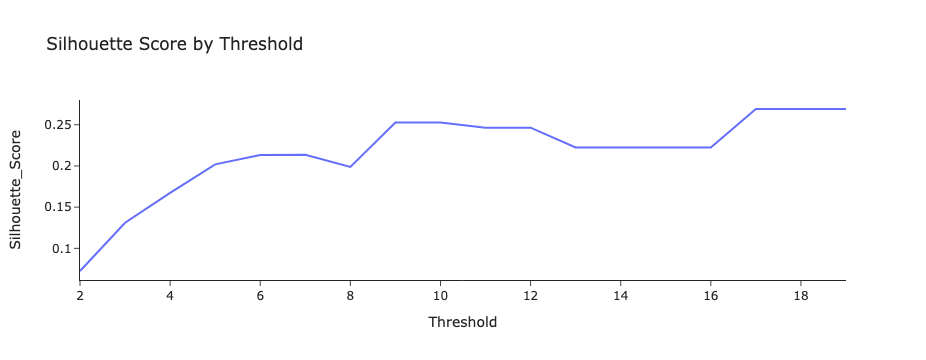

In [40]:
# Perform hierarchical clustering
linked = linkage(scaled_data, method='ward', metric='euclidean')

# Initialize variables
thresholds = range(2, 20)  # You can adjust this range
scores = []

# Loop through thresholds
for threshold in thresholds:
    temp_clusters = fcluster(linked, threshold, criterion='distance')
    score = silhouette_score(scaled_data, temp_clusters)
    scores.append(score)

# Create a DataFrame for plotting
df = pd.DataFrame({'Threshold': thresholds, 'Silhouette_Score': scores})

# Create the plot using Plotly Express
fig = px.line(df, x='Threshold', y='Silhouette_Score', title='Silhouette Score by Threshold')
render_fig(fig)

In [41]:
display(Markdown("Considering we want to avoid a to high number of cluster a threshold of 9 seems like a good option"))
# Perform clustering with SciPy
linked = linkage(scaled_data, method='ward', metric='euclidean')
threshold = 9  # Threshold based on your observation from the dendrogram
clusters = fcluster(linked, threshold, criterion='distance')
by_state_df_with_facts_cluster_df['cluster'] = clusters.astype("str")

Considering we want to avoid a to high number of cluster a threshold of 9 seems like a good option

Total Clusters: 5

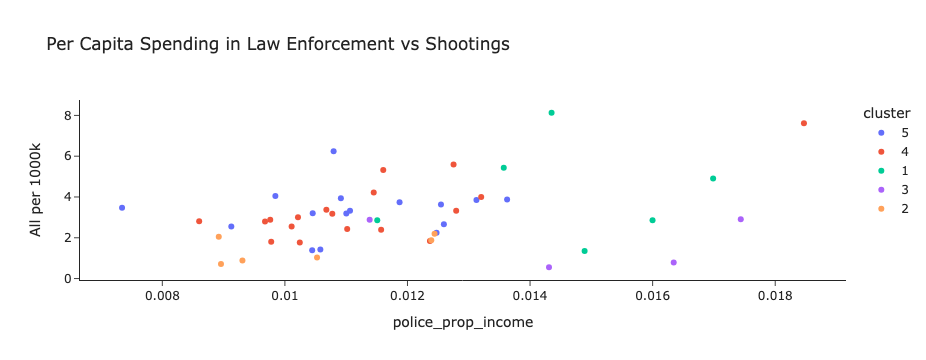

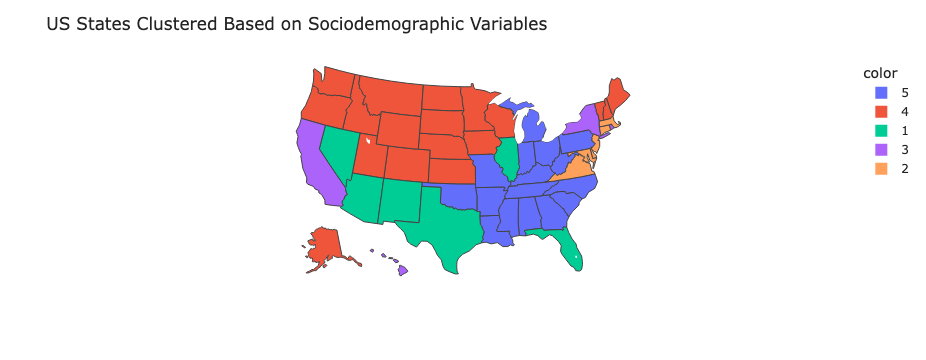

Gennerally the clustering results seem to be sensible, cultually and economically comparable states seem to be clustered together

 - Interestingly New-England seems to be split into two clusters. Norther more rural states are grouped together with states in the North-West, while the more urbanized ones are grouped with the Mid-Atlantic states.

 - New York, Rhode-Island and Califronia seem form their own cluster which is somewhat harder to explain

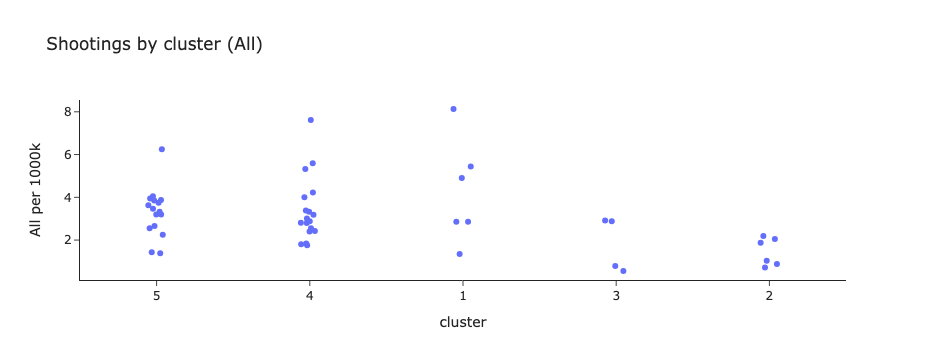

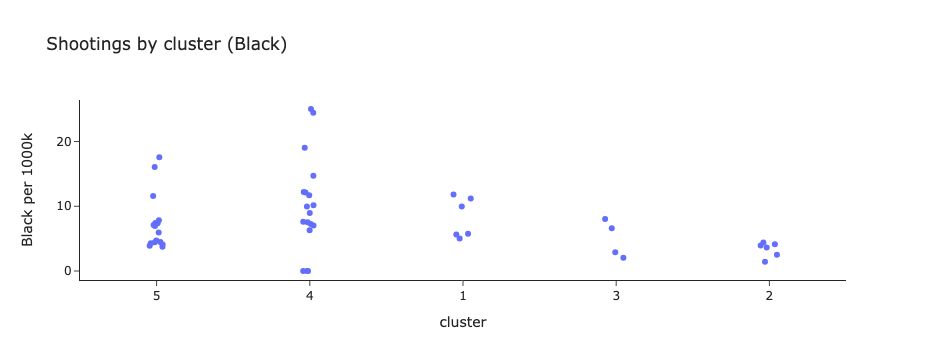

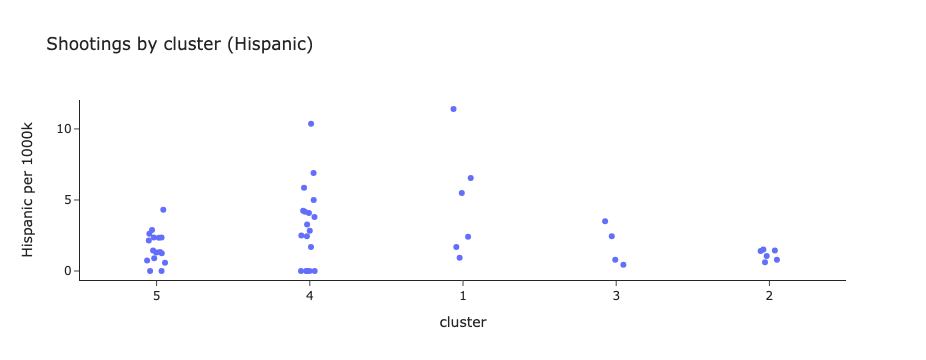

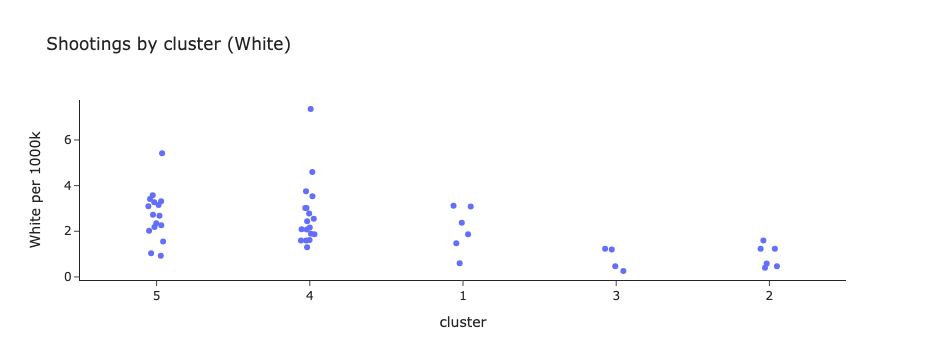

In [42]:
display(Markdown(f"Total Clusters: {len(by_state_df_with_facts_cluster_df['cluster'].unique())}"))

# Create scatter plot with Plotly Express
fig_scatter = px.scatter(by_state_df_with_facts_cluster_df.reset_index(),
                         x='police_prop_income',
                         title="Per Capita Spending in Law Enforcement vs Shootings",
                         y='All per 1000k',
                         hover_data="state",
                         color='cluster')
render_fig(fig_scatter)

fig = px.choropleth(
    locations=by_state_df_with_facts_cluster_df.index,
    locationmode="USA-states",
    color=by_state_df_with_facts_cluster_df["cluster"],

    scope="usa")
fig.update_layout(title='US States Clustered Based on Sociodemographic Variables')

fig.layout.dragmode = False
fig.layout.xaxis.fixedrange = True
fig.layout.yaxis.fixedrange = True
render_fig(fig)

display(Markdown(
    "Gennerally the clustering results seem to be sensible, cultually and economically comparable states seem to be clustered together"))
display(Markdown(
    " - Interestingly New-England seems to be split into two clusters. Norther more rural states are grouped together with states in the North-West, while the more urbanized ones are grouped with the Mid-Atlantic states."))
display(Markdown(
    " - New York, Rhode-Island and Califronia seem form their own cluster which is somewhat harder to explain"))

for k in ["All per 1000k", "Black per 1000k", "Hispanic per 1000k", "White per 1000k"]:
    fig = px.strip(by_state_df_with_facts_cluster_df.reset_index(), x="cluster", y=k,
                   hover_data="state",
                   title=f"Shootings by cluster ({k.split()[0]})"
                   )
    render_fig(fig)

Then purpose of clustering was to try to remove the influence of socio-demographic and economic factors on the prevalence of police shootings.

The assumption is that **variance in shooting rates between otherwise very similar states can be mostly explained by different government and law enforcement policies** which is something that could be changed more easily than deeper issues like poverty etc.

Looking at the states closest to each on the dendogram at a threshold of 4, we can see some pair of states which are very similar yet have very different rates of police shootings compared to the national average:
- Nevada (+1.8) & Texas (-0.2)
- Kansas (+0.1) & Nebraska (-0.6)
- Colorado (+2.2) & Washington (-0.3)
- North Caroline (-0.4) & Tennessee (+0.8)
- Montana (+0.6) & Ohio (-0.9)

We would be able to find even more examples by increasing the threshold (see the strip plots above).

While this is outside the scope of this analysis **we would suggest the Justice Department to start by comparing the law enforcement and other policies used in these state pairs with each other to try and determine whether the less successful states can adopt some the practices, training standards etc.**

array([5, 4, 1, 5, 3, 4, 2, 2, 1, 5, 3, 4, 1, 5, 4, 4, 5, 5, 4, 2, 2, 5,
       4, 5, 5, 4, 4, 1, 4, 2, 1, 3, 5, 4, 5, 5, 4, 5, 3, 5, 4, 5, 1, 4,
       4, 2, 4, 5, 4, 4], dtype=int32)

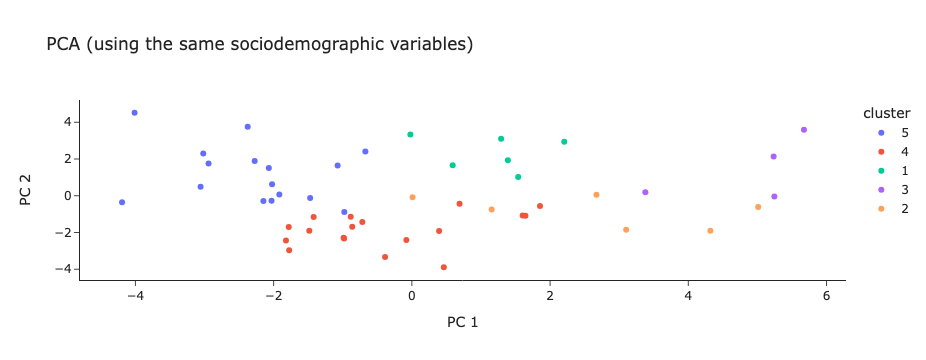

Explained variance: [0.37028356 0.24933625]

In [44]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(demo_clusters_df)

scores = []
sil_range = range(2, 12)

# Assume df is your DataFrame with the features you want to apply PCA on
pca = PCA(n_components=2)  # Number of components to keep
principal_components = pca.fit_transform(normalized_data)

# Convert the principal components to a DataFrame
principal_df = pd.DataFrame(data=principal_components, columns=['PC 1', 'PC 2'])

explained_variance = pca.explained_variance_ratio_

principal_df["All"] = by_state_df_with_facts_cluster_df["All"].tolist()
principal_df["All per 1000k"] = by_state_df_with_facts_cluster_df["All per 1000k"].tolist()
principal_df["state"] = by_state_df_with_facts_cluster_df.index.tolist()
principal_df["cluster"] = clusters.astype("str")

# Create scatter plot with Plotly Express
fig_scatter = px.scatter(principal_df,
                         x='PC 1',
                         y='PC 2',
                         title="PCA (using the same sociodemographic variables)",
                         hover_data="state",
                         color='cluster',
                         )
render_fig(fig_scatter)
display(Markdown(f"Explained variance: {explained_variance}"))

The variance explained by PCA is somewhat limited but not insignificant. 

Some clusters seem to be grouped closer to each other. However cluster 2 (Mid-Atlantic and some New England states) only makes sense when looking at Component 2 and doesn't make a lot of sense on the Component 1 axis.


#### 4. Building a Multiple Regression Model 

Let's build a statistical model to try and determine which of the demographic and other variables are best at explaining the variance in police shootings between different states.

We can't use Random Forest due to the low number of observations which would likely result in overfitting.

Multiple linear regression is also possibly not the best option due to the higher number of dependent variables in relation to the number of observations.

Let's look at the correlation between dependent variables before we chose a model:


In [45]:
reg_df = demo_clusters_df.copy()

# Fist let's remove some obviously multicollinear variables:
reg_df = reg_df.drop(
    columns=["Black or African American alone, percent", "Hispanic or Latino, percent", "Hispanic or Latino, percent"])

# Also some heavilly correalted variables:
reg_df = reg_df.drop(columns=["Language other than English spoken at home, pct age 5+"])

##### 1.3.1 Correlation and Preparing the Dataset

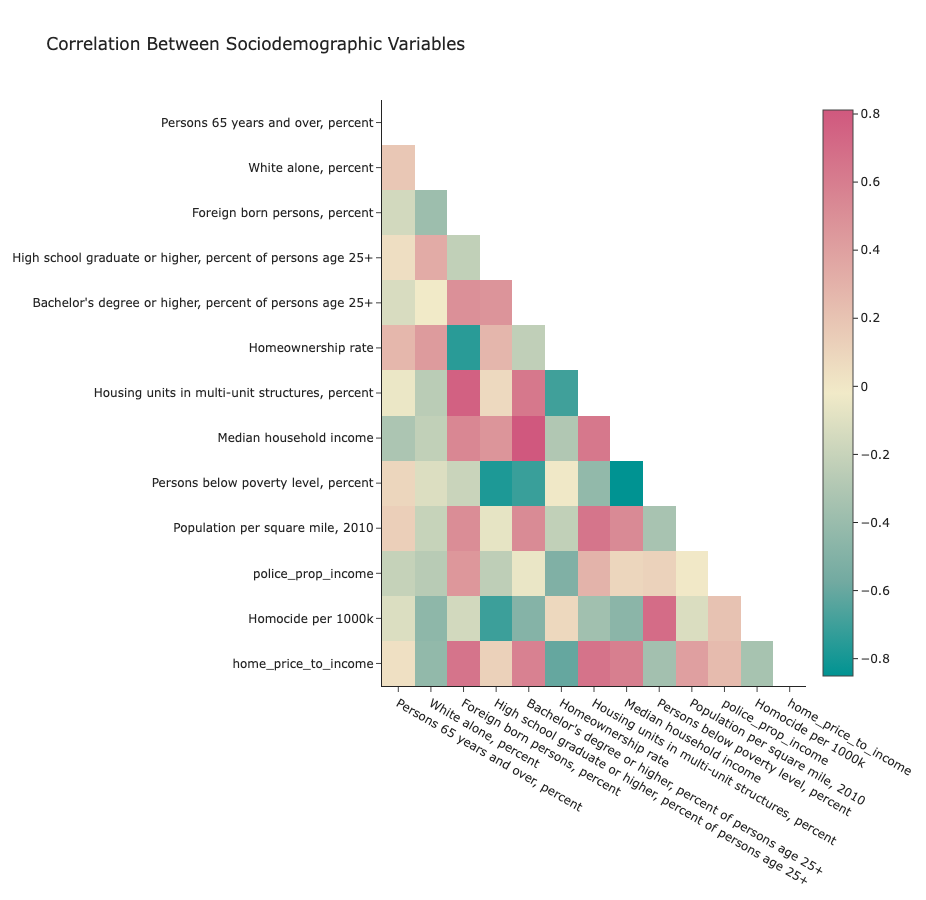

In [46]:
display(Markdown("##### 1.3.1 Correlation and Preparing the Dataset"))
# Compute correlation matrix
corr_matrix = reg_df.corr()

# Mask the upper triangle (keep lower triangle)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
masked_corr = np.where(mask, np.nan, corr_matrix)

# Reverse the rows for the heatmap to match the upper-right triangle
masked_corr = masked_corr[::-1]

# Create Plotly heatmap
fig = go.Figure(data=go.Heatmap(
    z=masked_corr,
    x=reg_df.columns,
    y=reg_df.columns[::-1],  # Reverse y labels as well
    colorscale='Tealrose',
    hoverongaps=False))

fig.update_layout(width=900, height=900, title='Correlation Between Sociodemographic Variables')
render_fig(fig)

In [47]:
display(Markdown("##### 1.3.2 Elastic Net Linear Regression Model"))

display(Markdown(
    "Considering that there is strong correlation between many of the variables we'll use the Elastic Net model instead of Lasso Regression for instance"))

y = by_state_df_with_facts_cluster_df["All per 1000k"]

standardized = StandardScaler().fit_transform(reg_df)
reg_df_st = pd.DataFrame(standardized, index=reg_df.index, columns=reg_df.columns)

# Define a range of alphas and l1_ratios for hyperparameter tuning
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]

# Use Leave-One-Out Cross-Validation (LOOCV) by settings the number of fold to
# the number of observations which is a good option when the dataset is small
model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=len(reg_df_st))
model.fit(reg_df_st, y)  # y is your dependent variable

# Assuming model.coef_ contains the coefficients, and X_standardized_df is your DataFrame
coefficients = pd.Series(model.coef_, index=reg_df_st.columns)
coefficients

##### 1.3.2 Elastic Net Linear Regression Model

Considering that there is strong correlation between many of the variables we'll use the Elastic Net model instead of Lasso Regression for instance

Persons 65 years and over, percent                           -0.131234
White alone, percent                                          0.000000
Foreign born persons, percent                                -0.000000
High school graduate or higher, percent of persons age 25+    0.000000
Bachelor's degree or higher, percent of persons age 25+      -0.000000
Homeownership rate                                           -0.220462
Housing units in multi-unit structures, percent              -0.739171
Median household income                                       0.000000
Persons below poverty level, percent                          0.064068
Population per square mile, 2010                             -0.422243
police_prop_income                                            0.466692
Homocide per 1000k                                            0.000000
home_price_to_income                                          0.077081
dtype: float64

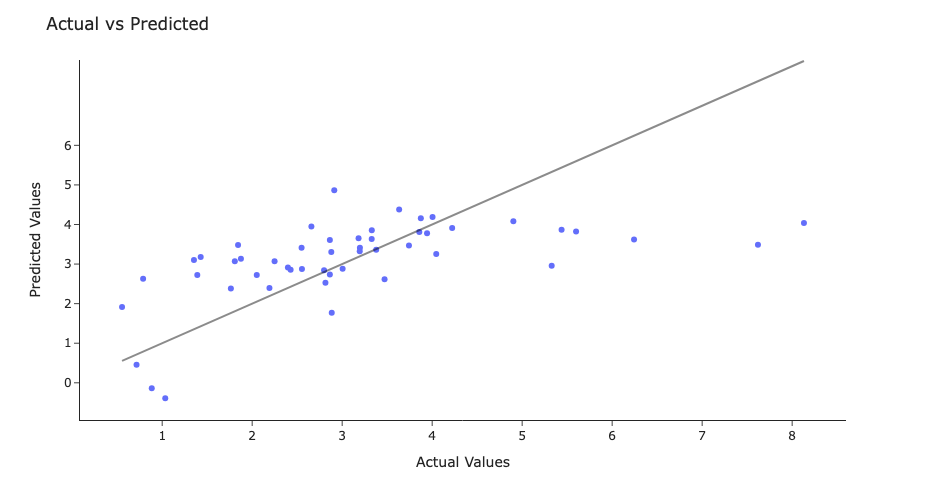

In [48]:
# Perform LOOCV and obtain the predicted values
# ElasticNetCV model
model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

# LOOCV object
loo = LeaveOneOut()

y_pred = cross_val_predict(model, reg_df_st, y, cv=50)

# Create a DataFrame containing the actual and predicted values
result_df = pd.DataFrame({
    'Actual': y,
    'Predicted': y_pred
})

# Add the index from the original DataFrame as a new column for hover information
result_df['Index'] = reg_df_st.index
# Create the scatter plot using Plotly Express
fig = px.scatter(result_df, x='Actual', y='Predicted', hover_data=['Index'],
                 labels={'Actual': 'Actual Values', 'Predicted': 'Predicted Values'})

fig.update_layout(template="simple_white")

# Add the 45-degree line
fig.add_shape(type='line',

              opacity=0.45, line_width=2,
              x0=result_df['Actual'].min(), y0=result_df['Actual'].min(),
              x1=result_df['Actual'].max(), y1=result_df['Actual'].max(),
              line=dict(color='black'))

# Update tickmode and tickvals for x and y axes
fig.update_xaxes(tickmode='array',
                 tickvals=list(range(int(result_df['Actual'].min()), int(result_df['Actual'].max()) + 1)))
fig.update_yaxes(tickmode='array',
                 tickvals=list(range(int(result_df['Predicted'].min()), int(result_df['Predicted'].max()) + 3)))

fig.update_layout(width=500, height=500, title='Actual vs Predicted')


def render_fig_1(fig, theme="simple_white"):
    fig.layout.xaxis.fixedrange = True
    fig.layout.yaxis.fixedrange = True
    fig.show(config={'displayModeBar': False})


# Show the plot
render_fig_1(fig)

##### 1.3.3 Interpreting Model Results

Any conclusions we make based on these results are obviously should be taken with a grain of salt however they do show some possibly surprising finding:

- Racial diversity/proportion of non-white population has no influence on the number of shootings per capita.
- However population density and concentration seem to be important factors. Specifically the proportion of people living in multi-unit housing units (apartments) seems to be the strongest predictor. There are likely several non straigforward interpretations of this however in combination with population density this might imply that:

    - police officers tend to behave different depending how likely other people and bystanders in general are to witness their actions.
    - Also it's possible that they feel less safe in less densely populated areas because it might take longer for other officers to reach them.
    - People shot by police are more likely to die if it occurs in areas with poor coverage by emergency services and it takes a long time for them to arrive.

    We can't test the validity of any of these hypothesis but it might be worth examining them further because they all seem to be highly actionable (improving police training, strategies for acting around dangerous individuals like waiting for backup etc.)

- Homicide rate seems to have no effect on the number of police shooting while the amount spent per capita on policing in the state is a relatively strong predictor.
    - this implies that there is not link between the general level of extreme violence in the state and the number of police shootings. This is highly concerned since using deadly force is only justifiable when the life of the officer or somebody else is in danger. However there seems to be no relationship between actual likelihood of a life threatening event occurring the decision by a law enforcement officer to use deadly force.

        This is something that certainly should be investigated further and is also possibly highly actionable. Especially because certain states handle this much better (like New York) and their practices might be applied in states which handle it much worse like New Mexico.

- High police spending seems to have a moderate effect on the incidence of police shooting combined with the homicide statistics this is also highly concerning. Increased spending on police, in this case at least, seems to produce a more negative outcome. It's hard to determine why this might be the case. However it's possible that significant proportions of funding might be miss-allocated (e.g. spent on unnecessary equipment etc.) and might better used to improve training. Even barring that it might mean that a smaller police presence might decrease the number of police shooting while have no effect on the murder rate (it's important to note that other crime statistics are not taken into account here).

#### Conclusions

- The difference in numbers can't be fully explained by "immutable" socio-demographic variables:
    - Black people are signficantly more likely to be shoot in states where they only make up a small proportion of the population:

      e.g. in Southern States the rate of police shootings of black people is much lower than in some norther and mid-western states. This might indicate that white police officers in those areas might target black people more often than in areas were African Americans are better integrated in local police departments etc.

      This phenomena can't be observed with other racial groups like Hispanics or Native Americans

    - There seems to be almost no **relationship between the murder rate and the incidence of police shootings in different states**.

      This is a crucial finding because it implies that a **higher levels of police shootings can't be explained by higher prevalence of violent crime**. This is something that certainly needs to be further looked into by the Justice department. One option would be to try to encourage then adoption of practices used in more successful states across the country.

    - **Higher police spending (as proportion of state per capita income) seems to result in a higher number of police shootings**. Taken together with the what we found about violent crime this is also highly concerning. Based on our modeling lower police spending has no effect on the homocide rate, this implies that overpolicing might be an issue (especially considering the recent trends in adoption of milatary grade weaponry and equipment across different police deparments).
 
      **It's possible that decreasing the spending on law enforcement might decrease the number of police shootings while having no effect on the homocide rate** however we have not looked into its relationship with the overall levels of crime.


- We can make no determinate conclusions on body camera usage:
   - While the proportion of police officers wearing a camera during shootings has increased over the last 8 years the number of shootings has actually increased. Without additional data we can't determine whether their adoption had limited effect or whether it's statistically not noticeable because the over number has increased due to other factors.
 
- Mental health seems to be an important are to tackle:
  - Significant variance between the proportion of mental health related police killings in states with similar overall number of shootings indicates that the law enforcement agencies and/or public health departments should try to adopt the best practices used in other states

- Police shooting rates seem to vary signficantly between some states which are very similar demographically, economically and urbanization wise.
    - **The justice department should perform a deeper analysis of the law enforcement policies practiced in some of the state pairs we've listed to try and determine whether the can be more widely adopted**. 

#### Limitations

 - The core of the analysis is based on differences US states. This means that the number of samples is quite and low and might be to low to for some mode. It might be worth going down a level or so and using Combined statistical area instead (collections of countries based on interconnected, usually urban areas).

 - It would be a good idea to look at more variables like the number of police interactions and the likelihood of them ending in a police shooting based on the target socio-economic status, race, mental state etc. and other factors like whether the officer is wearing a body camera, their training level etc. Of course such datasets are probably unobtainable without significant resources.

 - Besides the homicide rate we should also look at additional crime data, drug use and additional demographic variables like homelessness. 
